# Fit and SPAM seperation - first iteration
No quantum simulation in this one, just fits and comparison of distributions.

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

import json, os, sys
sys.path.append("../utils")

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

figures_path = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/IQ_plane_initial"

## Just dataloading

In [120]:
path = os.path.join(os.getcwd(), 'ss_data', "single_shot_1us_164010", "state_after.json")

durations = np.array([0.5, 1, 2, 5, 10])
names     = ["0p5us_164004", "1us_164010", "2us_164016", "5us_164020", "10us_164027"]

def get_IQ_states(folder_name):
    path = os.path.join(os.getcwd(), 'ss_data', f"single_shot_{folder_name}", "state_after.json")

    with open(path) as file:
        data = json.load(file)

    # Get the data
    IQ_state_0 = (
        1   * np.array(data["experiment_results"]["Readout signal (final_I) ss"]["value"])[:, 0] + 
        1j  * np.array(data["experiment_results"]["Readout signal (final_Q) ss"]["value"])[:, 0]
    )

    IQ_state_1 = (
        1   * np.array(data["experiment_results"]["Readout signal (final_I) ss"]["value"])[:, 1]+ 
        1j  * np.array(data["experiment_results"]["Readout signal (final_Q) ss"]["value"])[:, 1])
    
    return {"0": IQ_state_0, "1": IQ_state_1}


IQ_state_0 = []
IQ_state_1 = []
for name in names:
    IQ_states = get_IQ_states(name)
    IQ_state_0.append(IQ_states["0"])
    IQ_state_1.append(IQ_states["1"])
    
IQ_state_0 = np.array(IQ_state_0)
IQ_state_1 = np.array(IQ_state_1)

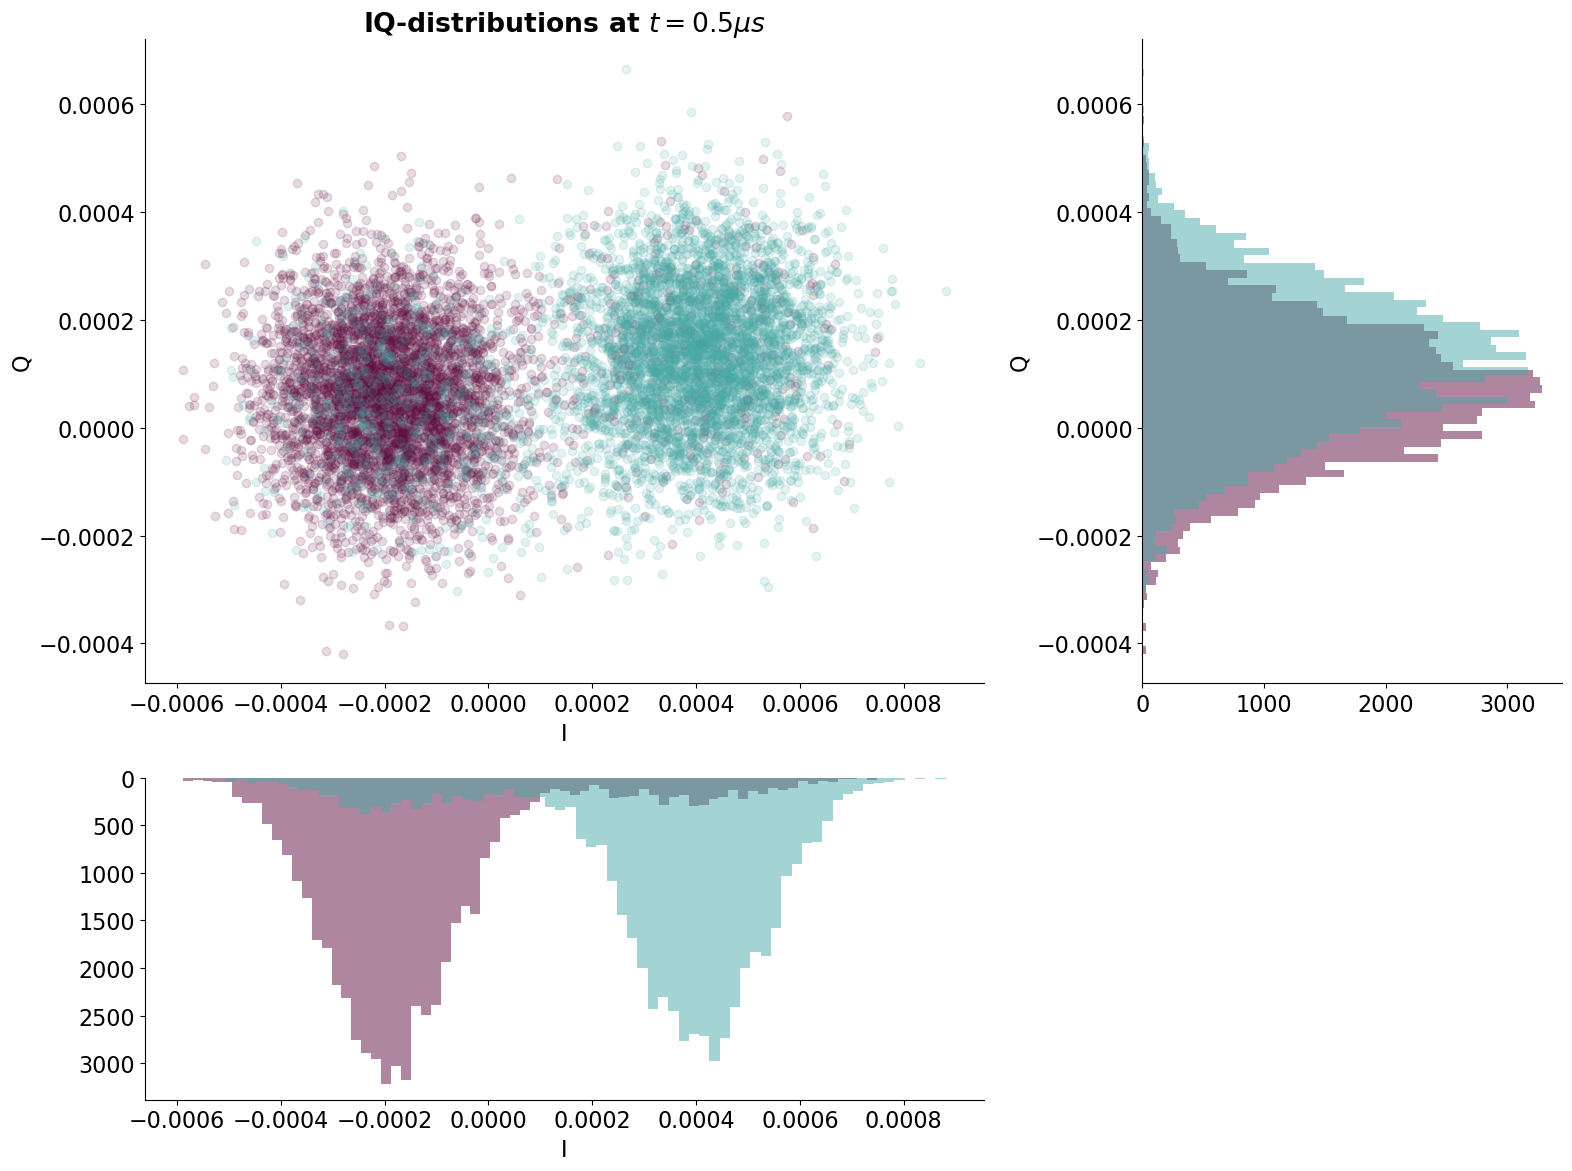

In [121]:
data_0 = IQ_state_0[0]
data_1 = IQ_state_1[0]

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (16, 12),
                       gridspec_kw = {"width_ratios": [2, 1], "height_ratios": [2, 1]})

ax_main = ax[0, 0]
ax_main.scatter(data_0.real, data_0.imag, alpha = 0.15, color = "C0");
ax_main.scatter(data_1.real, data_1.imag, alpha = 0.15, color = "C1");

ax_x = ax[1, 0]
ax_x.invert_yaxis()
ax_x.hist(data_0.real, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", density = True);
ax_x.hist(data_1.real, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", density = True);

ax_y = ax[0, 1]
ax_y.hist(data_0.imag, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);
ax_y.hist(data_1.imag, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);


ax[1 ,1].set_visible(False)

ax_main.set_xlabel("I")
ax_main.set_ylabel("Q")

ax_main.set_title("IQ-distributions at $t = 0.5 \mu s$")

ax_x.set_xlabel("I")

ax_y.set_ylabel("Q")

fig.tight_layout()

fig.savefig(os.path.join(figures_path, "IQ_raw_at_0.5.png"), dpi = 300)

# Fits of Distributions

## Fit of the 0.5 $\mu s$ measurement

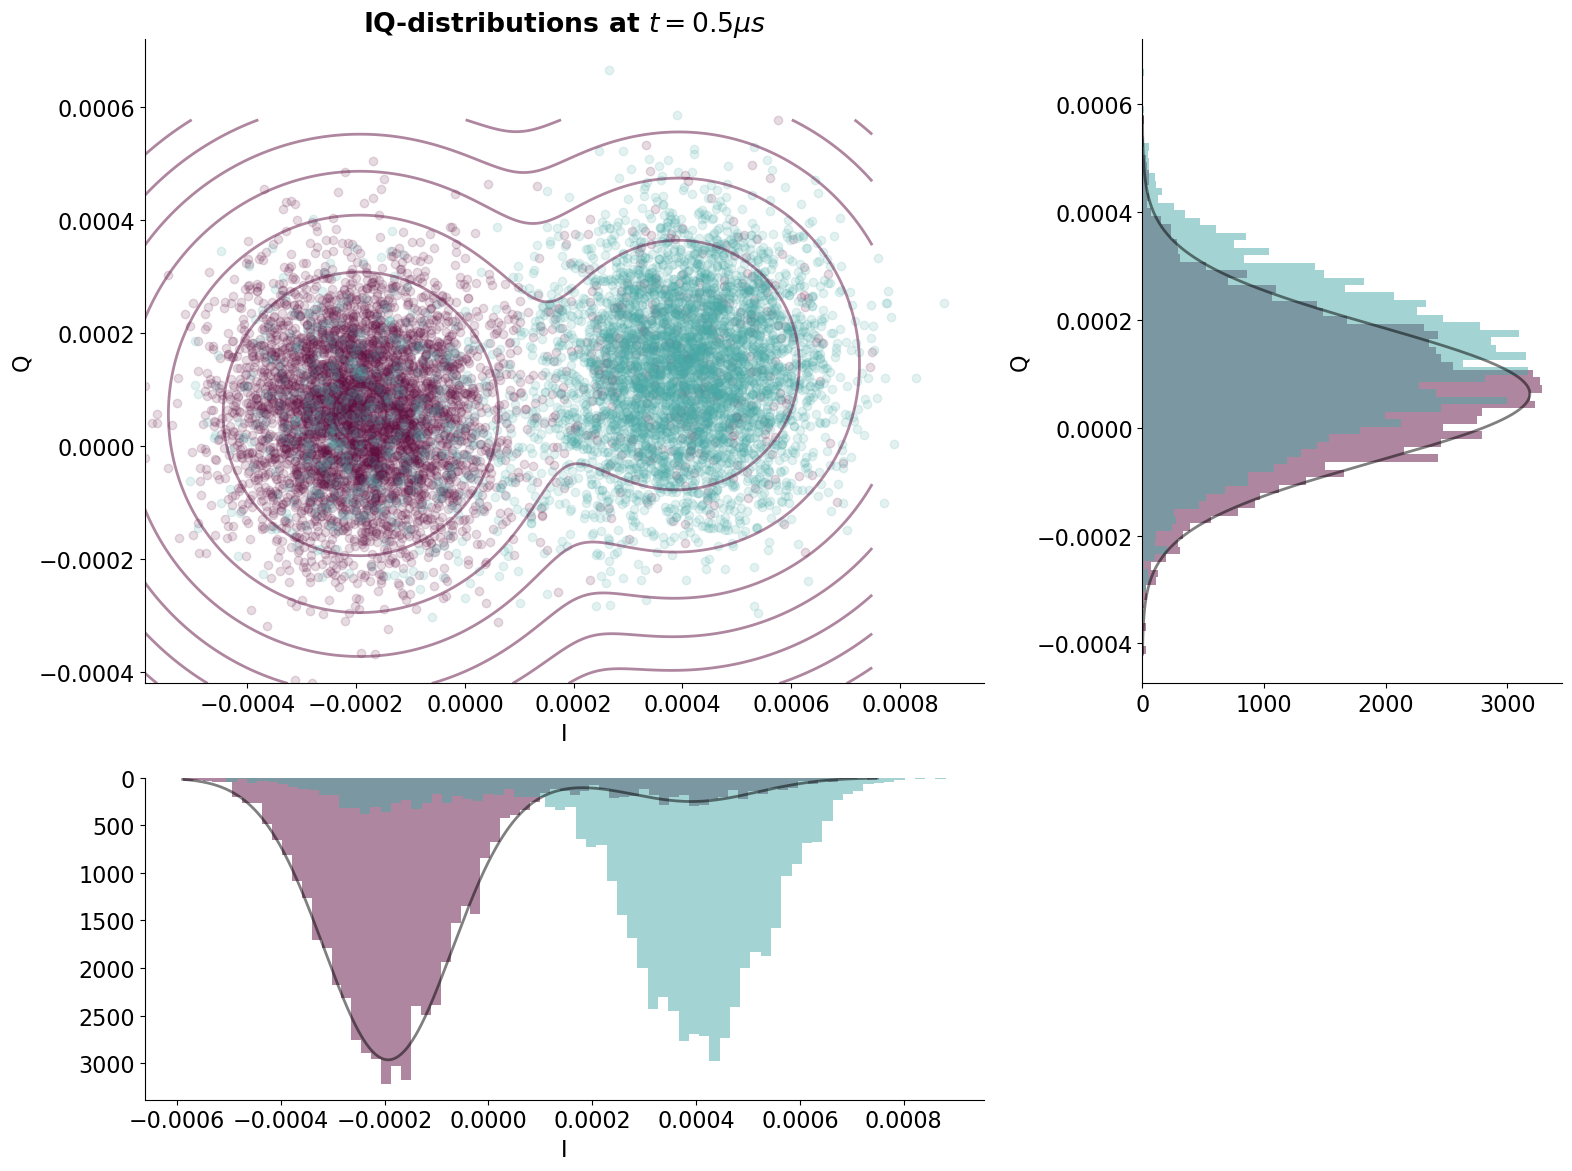

In [122]:
from scipy.stats import multivariate_normal, norm

def broad_gauss(data, mu_x1, mu_y1, mu_x2, mu_y2, sigma):
    data_real = data[:, 0] - mu_x1
    data_imag = data[:, 1] - mu_y1

    angle = np.arctan2(mu_y2 - mu_y1, mu_x2 - mu_x1)
    r     = np.sqrt((mu_x2 - mu_x1) ** 2 + (mu_y2 - mu_y1) ** 2)

    data_real_rot = + data_real * np.cos(angle) + data_imag * np.sin(angle)
    data_imag_rot = - data_real * np.sin(angle) + data_imag * np.cos(angle) 

    y_gauss = norm.pdf(data_imag_rot, 0, sigma)

    x_gauss = (norm.cdf(r, data_real_rot, sigma) - norm.cdf(0, data_real_rot, sigma))  / r


    return y_gauss * x_gauss


def double_gauss_with_broad(data, args):
    mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad = args

    multivariate_normal_1 = multivariate_normal([mu1_x, mu1_y], sigma ** 2 + 1e-15)
    multivariate_normal_2 = multivariate_normal([mu2_x, mu2_y], sigma ** 2 + 1e-15)

    pdf = (1 - f_broad - f_1) * multivariate_normal_1.pdf(data) + f_1 * multivariate_normal_2.pdf(data)
    

    broad     = f_broad * broad_gauss(data, mu1_x, mu1_y, mu2_x, mu2_y, sigma)

    return pdf + broad

def nllh(args, data):
    data = np.vstack([data.real, data.imag]).T
    pdfs = double_gauss_with_broad(data, args)
    pdfs = pdfs[pdfs > np.percentile(pdfs, 0.005)]
    return -2 * np.sum(np.log(pdfs))

from iminuit import Minuit

# Initial guess
mu1_x, mu1_y = -200.2e-6, 54.1e-6
mu2_x, mu2_y = 363e-6,  139e-6
sigma        = 108.3e-6
f_1          = 0.07
f_broad      = 0.00

minimizer_0_5_ground = Minuit(lambda x: nllh(x, data_0), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))

minimizer_0_5_ground.limits    = [(-3e-4, -1.5e-4), (0, 2e-4), (3e-4, 6e-4), (-2e-4, 2e-4), (1e-5, 2e-4), (0, 0.1), (0, 0.1)]

# minimizer_0_5_ground.fixed[-1] = True

minimizer_0_5_ground.migrad()

xs, ys = np.linspace(data_0.real.min(), data_0.real.max(), 1000), np.linspace(data_0.imag.min(), data_0.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_0_5_ground.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C0", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

fig

In [123]:
minimizer_0_5_ground

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.489e+05                 │              Nfcn = 228              │
│ EDM = 0.000116 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ -193.5e-6 │  2.2e-6   │            │            │ -0.0003 │-0.00015 │       │
│ 1 │ x1   │  57.3e-6  │  1.8e-6   │            │            │    0    │ 0.0002  │       │
│ 2 │ x2   │ 0.397e-3  │ 0.011e-3  │            │            │ 0.0003  │ 0.0006  │       │
│ 3 │ x3   │  145e-6   │   7e-6    │            │            │ -0.0002 │ 0.0002  │       │
│ 4 │ x4   │ 123.2e-6  │  1.0e-6   │            │            │  1e-05  │ 0.0002  │       │
│ 5 │ x5   │   0.073   │   0.007   │            │            │    0    │   0.1   │       │
│ 6 │ x6   │   0.016   │   0.013   │            │            │    0    │   0.1   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  4.84e-12  2.09e-13 -8.86e-12 -1.09e-12  6.28e-13  6.61e-09 -1.56e-08 │
│ x1 │  2.09e-13  3.36e-12 -1.16e-12 -4.92e-13  8.95e-14  9.05e-10 -2.14e-09 │
│ x2 │ -8.86e-12 -1.16e-12  1.27e-10  1.15e-11 -3.95e-12 -5.67e-08  1.15e-07 │
│ x3 │ -1.09e-12 -4.92e-13  1.15e-11  4.29e-11 -5.11e-13 -7.49e-09  1.51e-08 │
│ x4 │  6.28e-13  8.95e-14 -3.95e-12 -5.11e-13  1.04e-12  2.82e-09 -6.47e-09 │
│ x5 │  6.61e-09  9.05e-10 -5.67e-08 -7.49e-09  2.82e-09  5.21e-05 -8.14e-05 │
│ x6 │ -1.56e-08 -2.14e-09  1.15e-07  1.51e-08 -6.47e-09 -8.14e-05  0.000182 │
└────┴───────────────────────────────────────────────────────────────────────┘

In [124]:
# Initial guess
mu1_x, mu1_y = 413e-6,  139e-6
mu2_x, mu2_y = -200.2e-6, 54.1e-6
sigma        = 108.3e-6
f_1          = 0.100
f_broad      = 0.000

minimizer_0_5_excited = Minuit(lambda x: nllh(x, data_1), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))


minimizer_0_5_excited.limits = [(3e-4, 7e-4), (-2e-4, 2e-4),(-3e-4, -1.5e-4), (0, 2e-4), (1e-5, 2e-4), (0., 0.20), (0.0, 0.2)]
# minimizer_0_5_excited.fixed[-1]    = True
minimizer_0_5_excited.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.475e+05                 │              Nfcn = 245              │
│ EDM = 5.91e-05 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 408.9e-6  │  2.4e-6   │            │            │ 0.0003  │ 0.0007  │       │
│ 1 │ x1   │ 134.7e-6  │  2.0e-6   │            │            │ -0.0002 │ 0.0002  │       │
│ 2 │ x2   │  -181e-6  │   10e-6   │            │            │ -0.0003 │-0.00015 │       │
│ 3 │ x3   │   35e-6   │   6e-6    │            │            │    0    │ 0.0002  │       │
│ 4 │ x4   │ 127.2e-6  │  1.1e-6   │            │            │  1e-05  │ 0.0002  │       │
│ 5 │ x5   │   0.097   │   0.008   │            │            │    0    │   0.2   │       │
│ 6 │ x6   │   0.031   │   0.016   │            │            │    0    │   0.2   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  5.87e-12  4.24e-13 -8.62e-12 -1.86e-12 -8.02e-13 -9.11e-09  2.17e-08 │
│ x1 │  4.24e-13  3.79e-12 -1.17e-12 -7.89e-13 -1.52e-13 -1.49e-09  3.82e-09 │
│ x2 │ -8.62e-12 -1.17e-12  9.73e-11  9.37e-12  3.57e-12  5.77e-08 -1.14e-07 │
│ x3 │ -1.86e-12 -7.89e-13  9.37e-12   3.4e-11  7.57e-13  9.46e-09 -2.08e-08 │
│ x4 │ -8.02e-13 -1.52e-13  3.57e-12  7.57e-13  1.14e-12  3.51e-09 -8.06e-09 │
│ x5 │ -9.11e-09 -1.49e-09  5.77e-08  9.46e-09  3.51e-09  7.17e-05 -0.000113 │
│ x6 │  2.17e-08  3.82e-09 -1.14e-07 -2.08e-08 -8.06e-09 -0.000113  0.000251 │
└────┴───────────────────────────────────────────────────────────────────────┘

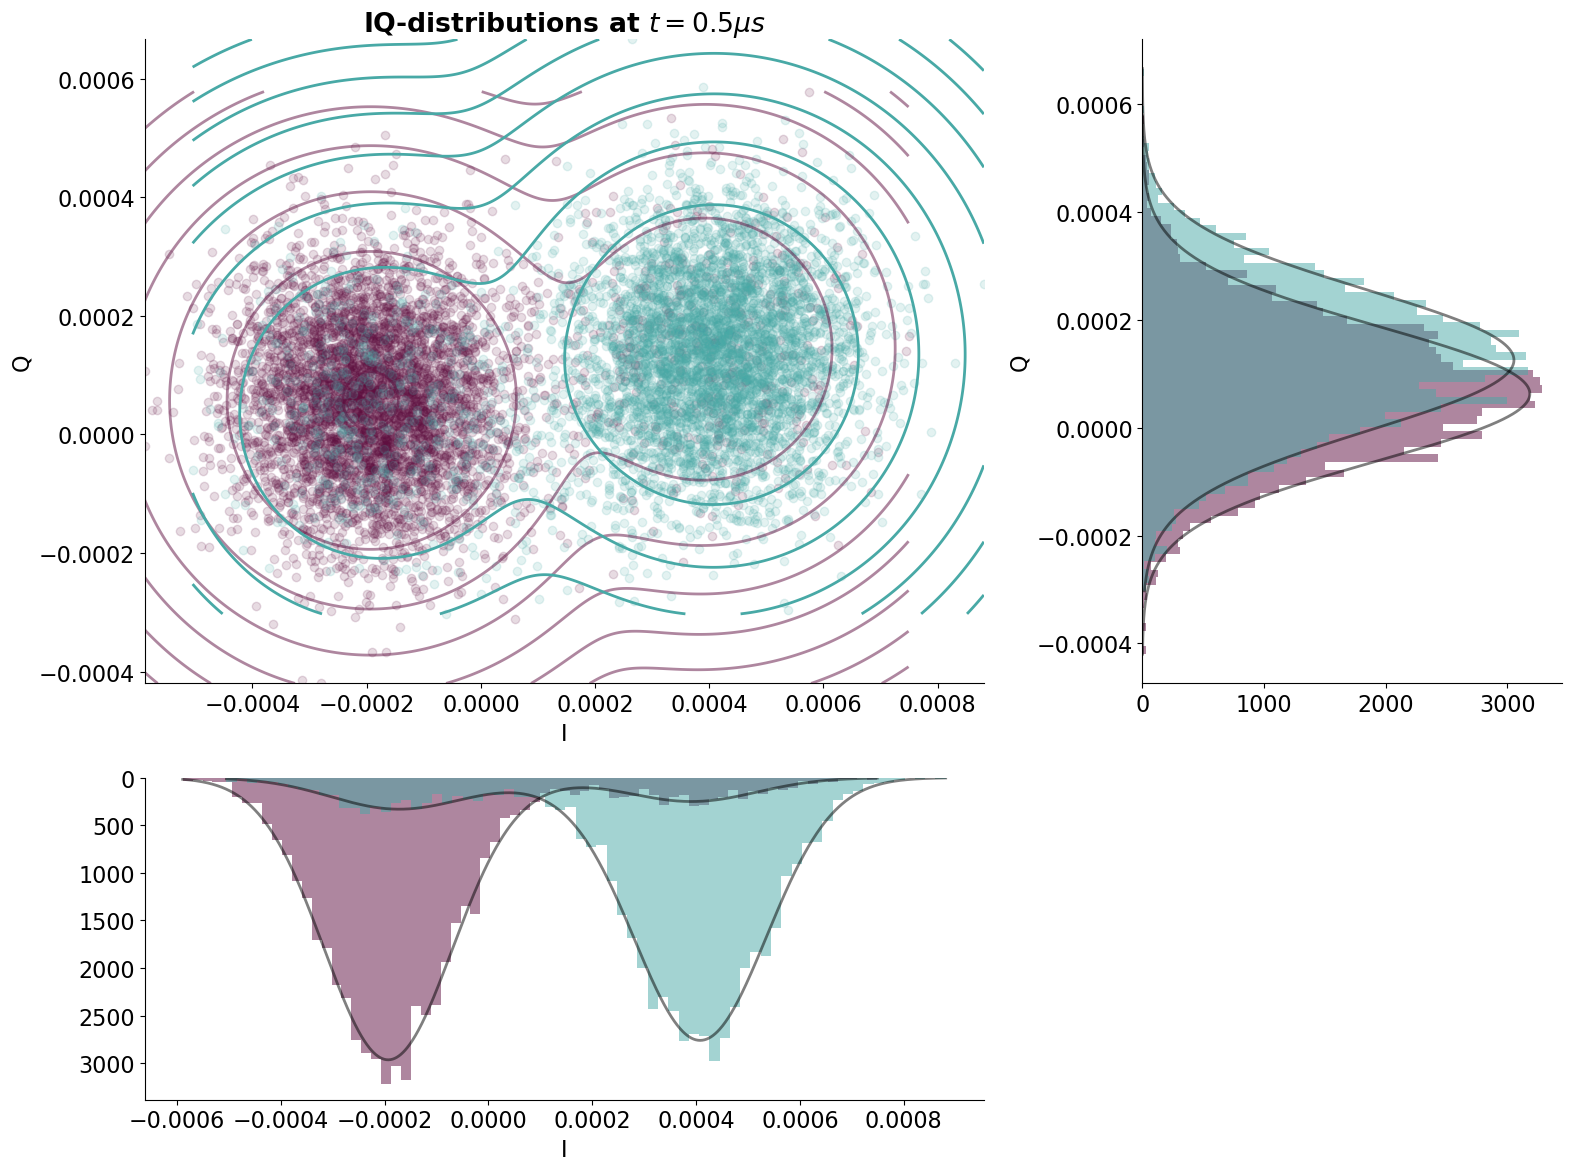

In [125]:
xs, ys = np.linspace(data_1.real.min(), data_1.real.max(), 1000), np.linspace(data_1.imag.min(), data_1.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_0_5_excited.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C1", linewidths = 2, alpha = 1)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)


fig

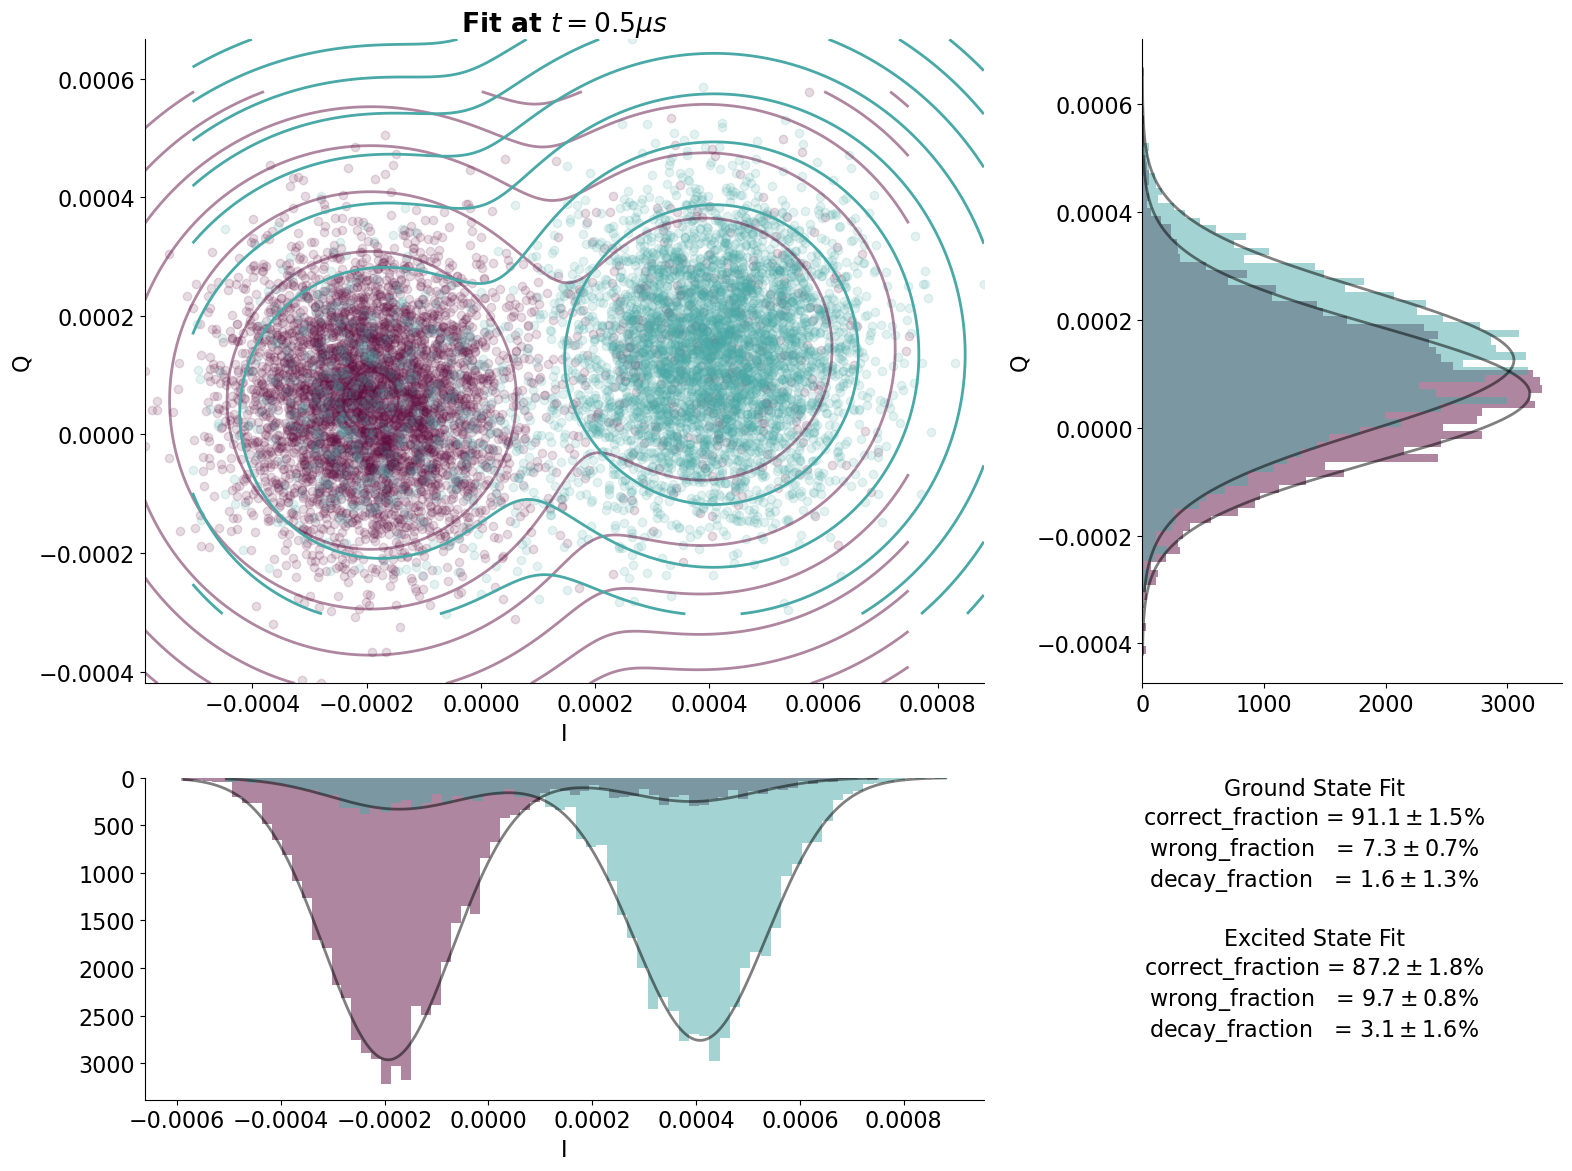

In [126]:
ax_main.set(
    xlabel = "I",
    ylabel = "Q",
    title  = "Fit at $t = 0.5 \mu s$"
)

ax_y.set_ylabel("Q")
ax_x.set_xlabel("I")

frac_correct = 100 * (1  - minimizer_0_5_ground.values[5] - minimizer_0_5_ground.values[6])
frac_correct_err = 100 * np.sqrt(minimizer_0_5_ground.errors[5]**2 + minimizer_0_5_ground.errors[6]**2)

frac_wrong   = 100 * minimizer_0_5_ground.values[5]
frac_wrong_err   = 100 * minimizer_0_5_ground.errors[5]

frac_decay   = 100 * minimizer_0_5_ground.values[6]
frac_decay_err   = 100 * minimizer_0_5_ground.errors[6]

fit0_text = f"""
Ground State Fit
correct_fraction = ${frac_correct:2.1f} \pm {frac_correct_err:.1f} \%$
wrong_fraction   = ${frac_wrong:2.1f} \pm {frac_wrong_err:.1f} \%$
decay_fraction   = ${frac_decay:2.1f} \pm {frac_decay_err:.1f} \%$
"""

fig.text(0.83, 0.225, fit0_text, fontsize = 16, ha = "center")

frac_correct = 100 * (1  - minimizer_0_5_excited.values[5] - minimizer_0_5_excited.values[6])
frac_correct_err = 100 * np.sqrt(minimizer_0_5_excited.errors[5]**2 + minimizer_0_5_excited.errors[6]**2)

frac_wrong   = 100 * minimizer_0_5_excited.values[5]
frac_wrong_err   = 100 * minimizer_0_5_excited.errors[5]

frac_decay   = 100 * minimizer_0_5_excited.values[6]
frac_decay_err   = 100 * minimizer_0_5_excited.errors[6]

fit0_text = f"""
Excited State Fit
correct_fraction = ${frac_correct:2.1f}  \pm  {frac_correct_err:.1f} \%$
wrong_fraction   = ${frac_wrong:2.1f}  \pm  {frac_wrong_err:.1f} \%$
decay_fraction   = ${frac_decay:2.1f}  \pm  {frac_decay_err:.1f} \%$
"""

fig.text(0.83, 0.10, fit0_text, fontsize = 16, ha = "center")

fig.savefig(os.path.join(figures_path, "fit_0_5.pdf"))

fig


## Analysis of the 0.5 $\mu s$ Measurement
The following section, we try, what can be found from these samples:

For the further analysis, we assume that the states have note decayed up untill this point. For $\ket{0}$ we neglect the thermal excitations after the readout has started. While for $\ket{1}$, the assumption is, that most of the error is from flipped 0, but the addition is fidelty in x-gate + some contribution of qubit decay in the first half second. This can't necessarily be fitted in this, but with more information later, we are in a better position to do this.

We find the interesting values given as probabilities of being in either 1 or 0 depending on initialization.

Initialization in 0:
$$ p_0(\ket{0}) = 0.917 \pm 0.004$$
$$ p_1(\ket{0}) = 0.083 \pm 0.004$$

And initialization in 1:
$$ p_0(\ket{1}) = 0.109 \pm 0.005$$
$$ p_1(\ket{1}) = 0.891 \pm 0.005$$


## Temperature

The $p_0(\ket{1})$ must be the steady state of excitments of the system and the T1 decay. 

Given equilibrium conditions, then the probability of being in state 1 should be given by the boltzmann distribution as:
$$ p_1 = \frac{\exp(-\beta \hbar \omega)}{1 + \exp(-\beta \hbar \omega)}$$

We can isolate $\beta$ by:

$$ \beta = \frac{1}{\hbar \omega} \ln \frac{p_1}{1-p_1}$$

Or the temperatur as:

$$ T = \frac{1}{\beta k_B} =\frac{\hbar \omega}{k_B} \;/\; \ln \frac{p_1}{1 - p_1}$$

We find the temperature:

In [127]:
hbar = 1.054e-34
kb   = 1.38e-23

omega = 2 * np.pi * 5962153857.0

p_1_given_0 = 0.083


T = hbar / kb * omega  / np.log((1 - p_1_given_0) / p_1_given_0)

# Error is simply found by sampling
p_1_sample = np.random.normal(0.083, 0.004, 10000)
T_sample = hbar / kb * omega  / np.log((1 - p_1_sample) / p_1_sample)
T_err    = np.std(T_sample)


print(f"Temperature is {T * 1e3:.2f} +/- {T_err * 1e3:.2f} mK")


Temperature is 119.10 +/- 2.60 mK


This gives an estimate of the temperature at: $T = 119 \pm 3 \text{ mK}$

## Asymmetric Error

We now turn our eye to the assymetry between the error when preparing $\ket{0}$ and $\ket{1}$

In [128]:
diff        = 0.109 - 0.083
diff_err    = np.sqrt(0.004 ** 2 + 0.005 ** 2) 

print(f"Diff is: {diff * 1e2:.2f} +/- {diff_err * 1e2:.2f} %")

Diff is: 2.60 +/- 0.64 %


$$ \Delta = p_0(\ket{0}) - p_1(\ket{1}) = 2.60 \pm 0.64 \;\% $$

At low percentages, this is assumed to be errors due to the x-gate flipping $\ket{0}$ to $\ket{1}$ and then a contribution from $T_1$ decay over the first half mikrosecond.

## Fit of the 1 $\mu s$ measurement


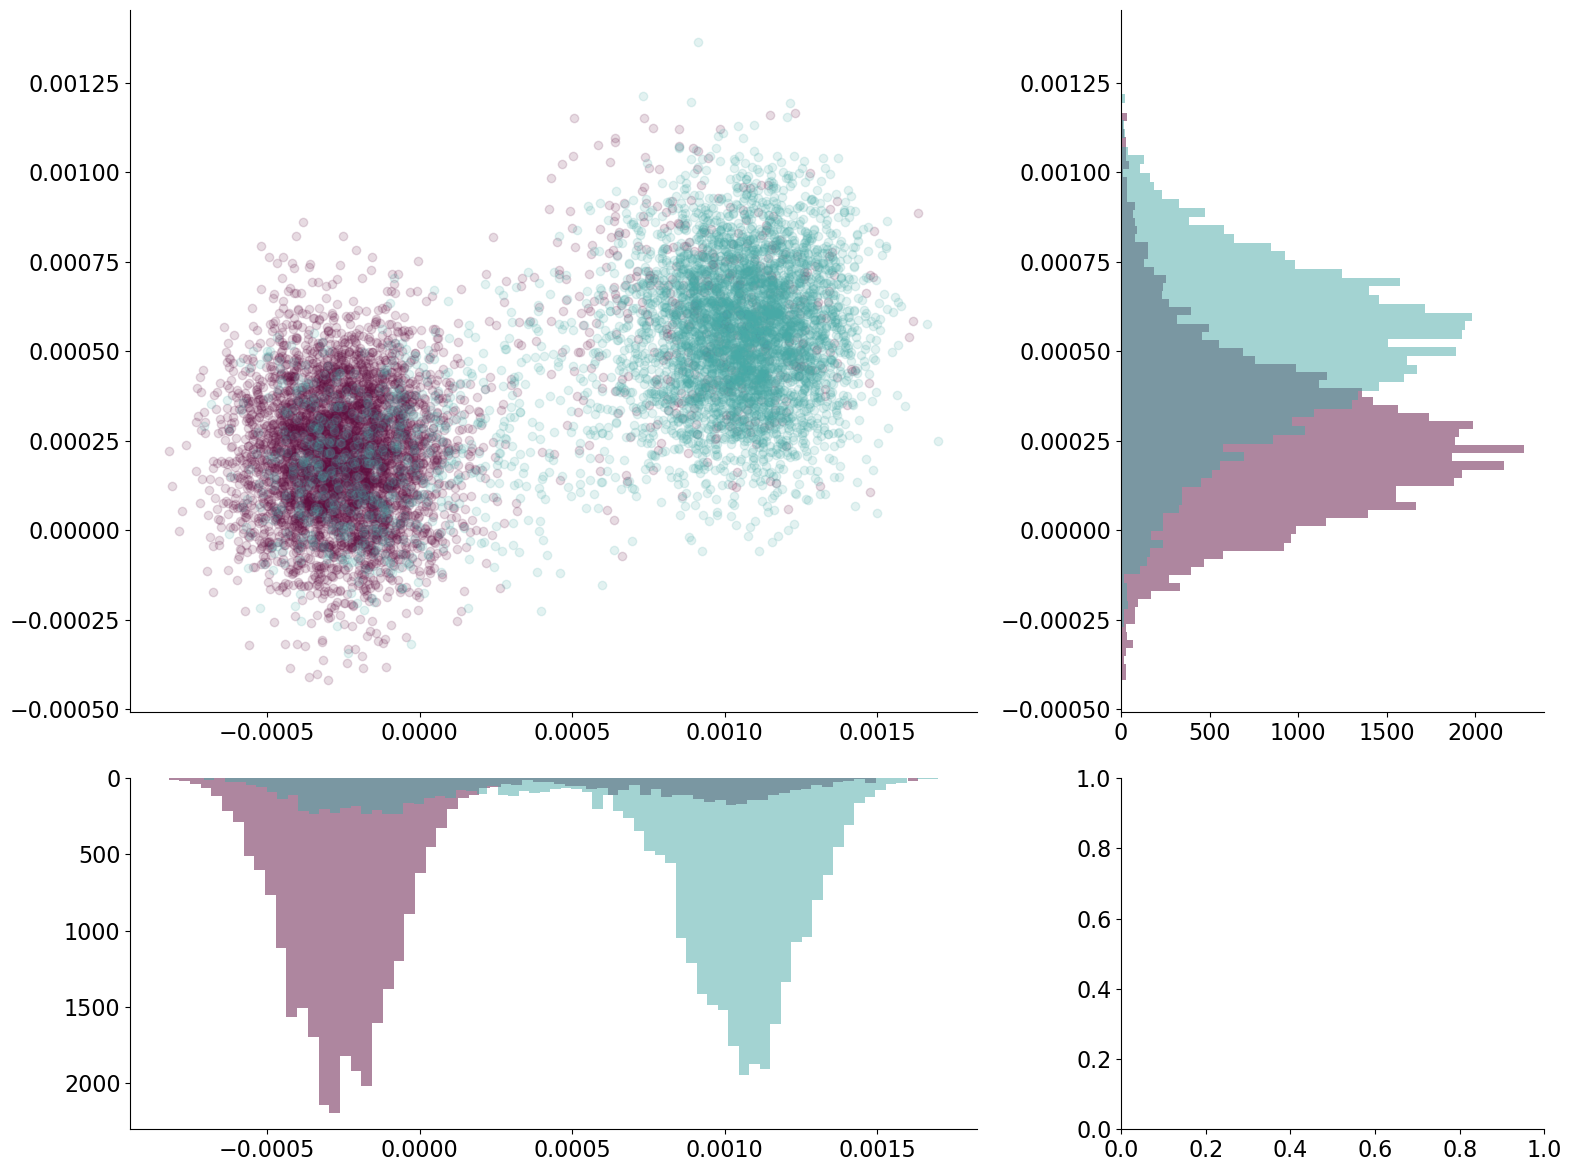

In [129]:
data_0 = IQ_state_0[1]
data_1 = IQ_state_1[1]

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (16, 12),
                       gridspec_kw = {"width_ratios": [2, 1], "height_ratios": [2, 1]})

ax_main = ax[0, 0]
ax_main.scatter(data_0.real, data_0.imag, alpha = 0.15, color = "C0");
ax_main.scatter(data_1.real, data_1.imag, alpha = 0.15, color = "C1");

ax_x = ax[1, 0]
ax_x.invert_yaxis()
ax_x.hist(data_0.real, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", density = True);
ax_x.hist(data_1.real, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", density = True);

ax_y = ax[0, 1]
ax_y.hist(data_0.imag, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);
ax_y.hist(data_1.imag, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);

fig.tight_layout()

In [130]:
# Initial guess
mu1_x, mu1_y = -500e-6,     100e-6
mu2_x, mu2_y = 1500e-6,     750e-6
sigma        = 250.3e-6
f_1          = 0.100
f_broad      = 0.00

minimizer_1_ground = Minuit(lambda x: nllh(x, data_0), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_1_ground.fixed[-1] = True

minimizer_1_ground.limits = [(-3e-4, -1.5e-4), (0, 5e-4), (5e-4, 15e-4), (5e-4, 15e-4),  (1e-5, 2e-4), (0, 1.0), (0, 0.1)]
minimizer_1_ground.migrad()

xs, ys = np.linspace(data_0.real.min(), data_0.real.max(), 1000), np.linspace(data_0.imag.min(), data_0.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_1_ground.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C0", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

minimizer_1_ground

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.406e+05                 │              Nfcn = 315              │
│ EDM = 9.54e-05 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ -261.0e-6 │  2.8e-6   │            │            │ -0.0003 │-0.00015 │       │
│ 1 │ x1   │ 205.0e-6  │  2.7e-6   │            │            │    0    │ 0.0005  │       │
│ 2 │ x2   │ 1.008e-3  │ 0.012e-3  │            │            │ 0.0005  │ 0.0015  │       │
│ 3 │ x3   │  611e-6   │   9e-6    │            │            │ 0.0005  │ 0.0015  │       │
│ 4 │ x4   │ 179.0e-6  │  1.3e-6   │            │            │  1e-05  │ 0.0002  │       │
│ 5 │ x5   │   0.074   │   0.005   │            │            │    0    │    1    │       │
│ 6 │ x6   │   0.037   │   0.005   │            │            │    0    │   0.1   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  7.67e-12   1.6e-13 -2.58e-12 -5.09e-13  2.51e-13  9.67e-10 -2.64e-09 │
│ x1 │   1.6e-13  7.19e-12 -2.01e-13 -7.62e-13  7.12e-14     2e-10 -6.82e-10 │
│ x2 │ -2.58e-12 -2.01e-13  1.49e-10  1.97e-11  -2.5e-12 -2.18e-08   3.2e-08 │
│ x3 │ -5.09e-13 -7.62e-13  1.97e-11  8.06e-11 -6.75e-13 -5.92e-09  8.69e-09 │
│ x4 │  2.51e-13  7.12e-14  -2.5e-12 -6.75e-13  1.81e-12  7.83e-10 -1.52e-09 │
│ x5 │  9.67e-10     2e-10 -2.18e-08 -5.92e-09  7.83e-10  2.13e-05 -1.21e-05 │
│ x6 │ -2.64e-09 -6.82e-10   3.2e-08  8.69e-09 -1.52e-09 -1.21e-05  2.91e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

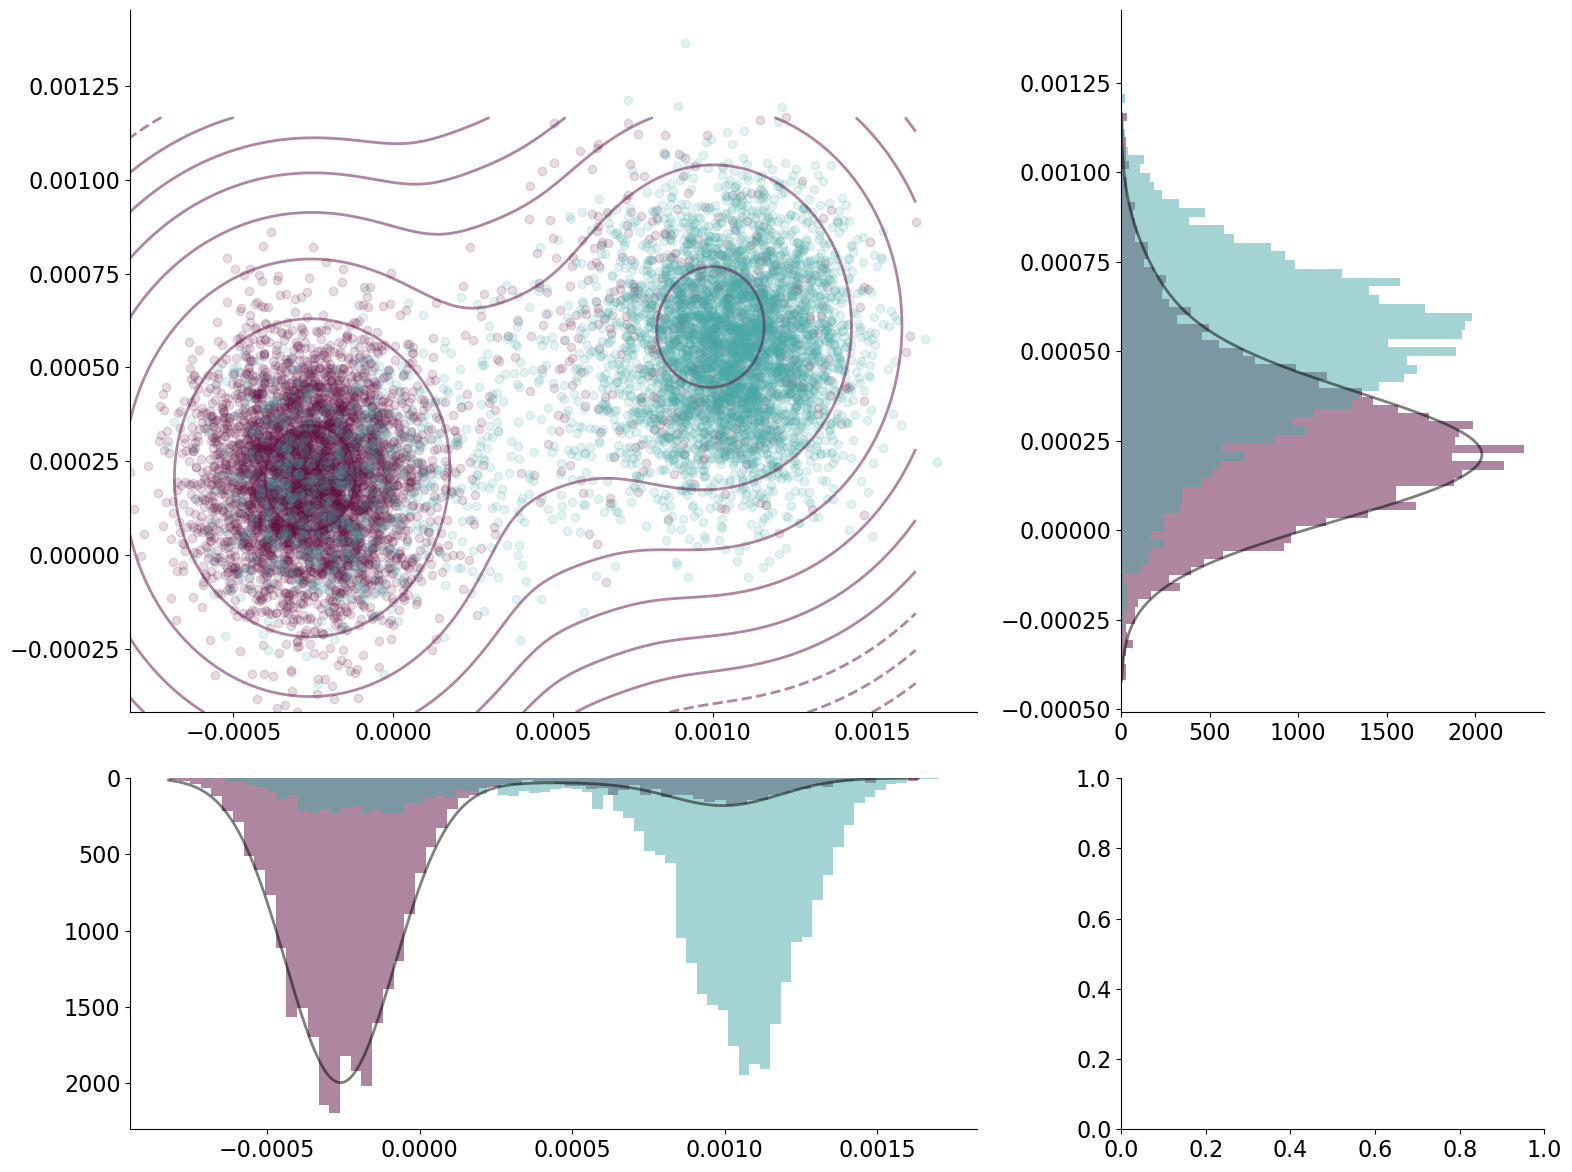

In [131]:
fig

In [132]:
# Initial guess
mu1_x, mu1_y = 1000e-6,     750e-6 
mu2_x, mu2_y = -500e-6,     200e-6
sigma        = 250.3e-6
f_1          = 0.100
f_broad      = 0.100

minimizer_1_excited = Minuit(lambda x: nllh(x, data_1), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_1_excited.fixed[-1] = True

minimizer_1_excited.limits = [(5e-4, 15e-4), (5e-4, 15e-4),  (-3e-4, 3e-4), (0, 5e-4), (1e-5, 4e-4), (0, 1.0), (0.05, 0.15)]
minimizer_1_excited.migrad()

xs, ys = np.linspace(data_1.real.min(), data_1.real.max(), 1000), np.linspace(data_1.imag.min(), data_1.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_1_excited.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C1", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

fig.show()

minimizer_1_excited

/tmp/ipykernel_8226/133483367.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.385e+05                 │              Nfcn = 230              │
│ EDM = 0.000121 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 1.0711e-3 │ 0.0031e-3 │            │            │ 0.0005  │ 0.0015  │       │
│ 1 │ x1   │ 557.4e-6  │  2.9e-6   │            │            │ 0.0005  │ 0.0015  │       │
│ 2 │ x2   │ -0.230e-3 │ 0.011e-3  │            │            │ -0.0003 │ 0.0003  │       │
│ 3 │ x3   │  162e-6   │   8e-6    │            │            │    0    │ 0.0005  │       │
│ 4 │ x4   │ 183.6e-6  │  1.4e-6   │            │            │  1e-05  │ 0.0004  │       │
│ 5 │ x5   │   0.093   │   0.006   │            │            │    0    │    1    │       │
│ 6 │ x6   │   0.101   │   0.008   │            │            │  0.05   │  0.15   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  9.83e-12   5.4e-13 -3.47e-12 -7.19e-13 -6.21e-13 -2.07e-09  6.88e-09 │
│ x1 │   5.4e-13  8.27e-12 -5.24e-13 -1.58e-12 -1.86e-13 -6.09e-10  2.09e-09 │
│ x2 │ -3.47e-12 -5.24e-13  1.25e-10  2.04e-11   2.7e-12  2.88e-08  -4.1e-08 │
│ x3 │ -7.19e-13 -1.58e-12  2.04e-11  6.14e-11  8.39e-13  8.61e-09 -1.25e-08 │
│ x4 │ -6.21e-13 -1.86e-13   2.7e-12  8.39e-13   2.1e-12  1.22e-09 -2.81e-09 │
│ x5 │ -2.07e-09 -6.09e-10  2.88e-08  8.61e-09  1.22e-09  3.18e-05 -2.47e-05 │
│ x6 │  6.88e-09  2.09e-09  -4.1e-08 -1.25e-08 -2.81e-09 -2.47e-05  6.48e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

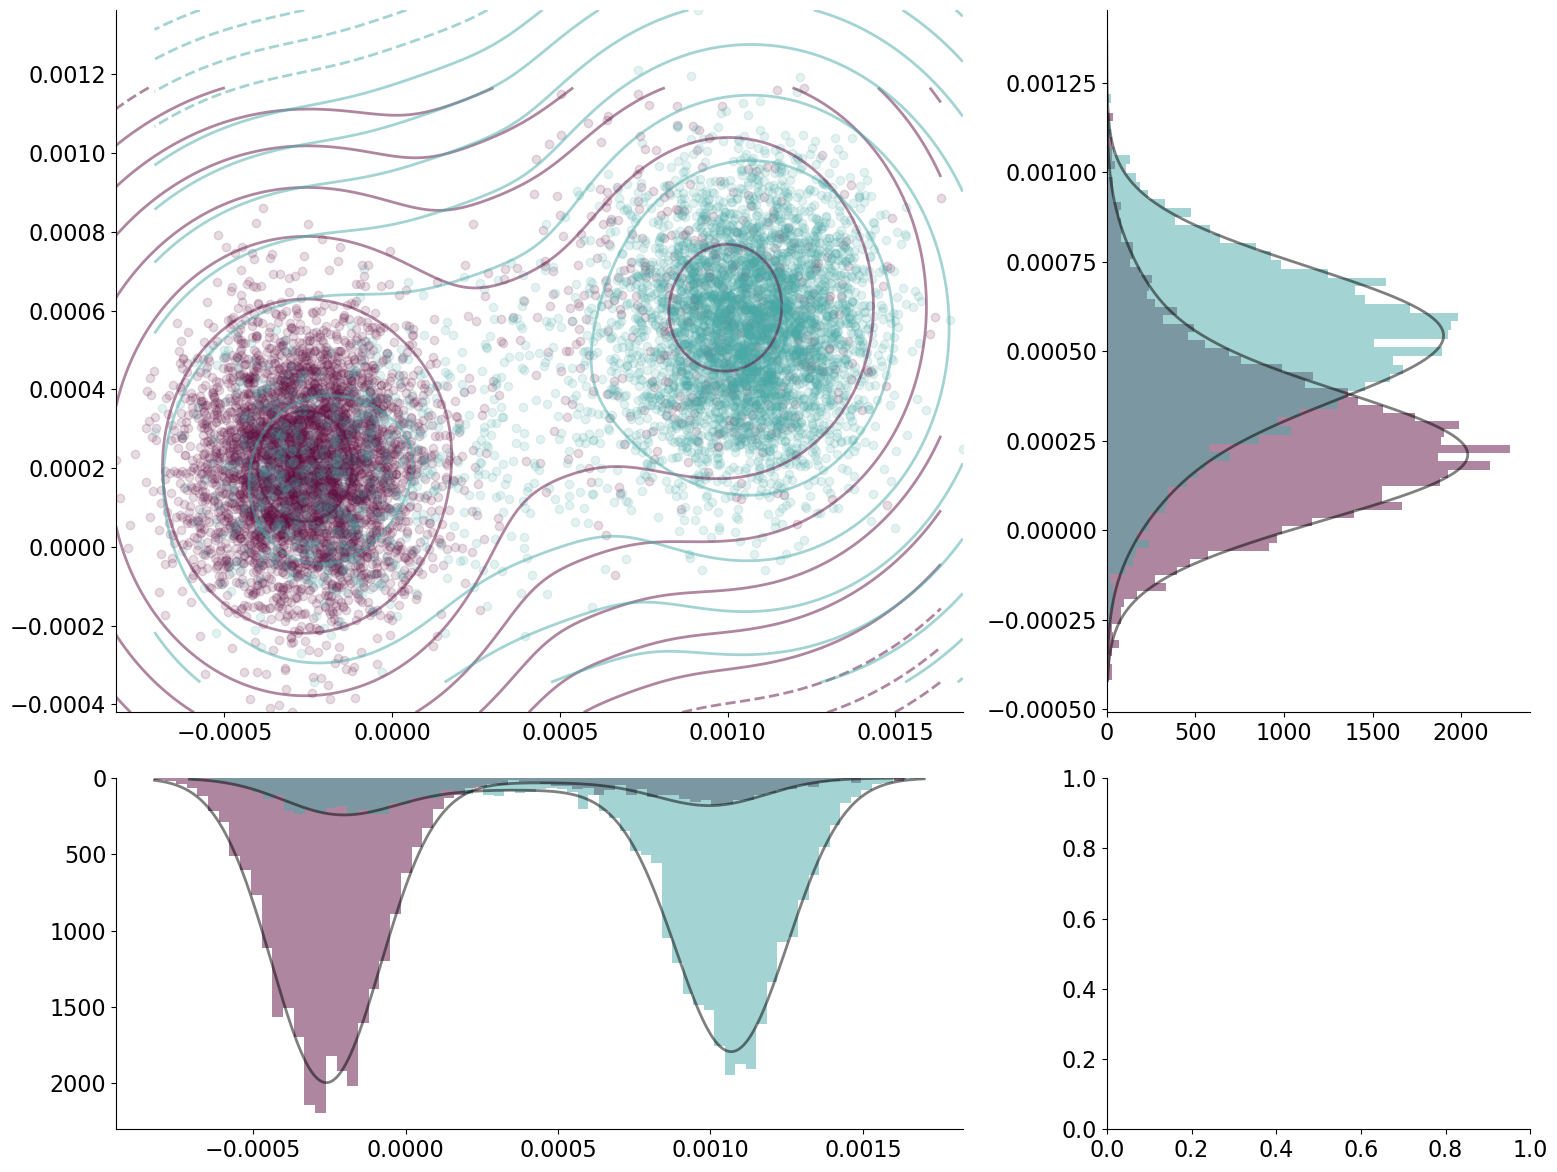

In [133]:
fig

## Fitting 2 $\mu s$

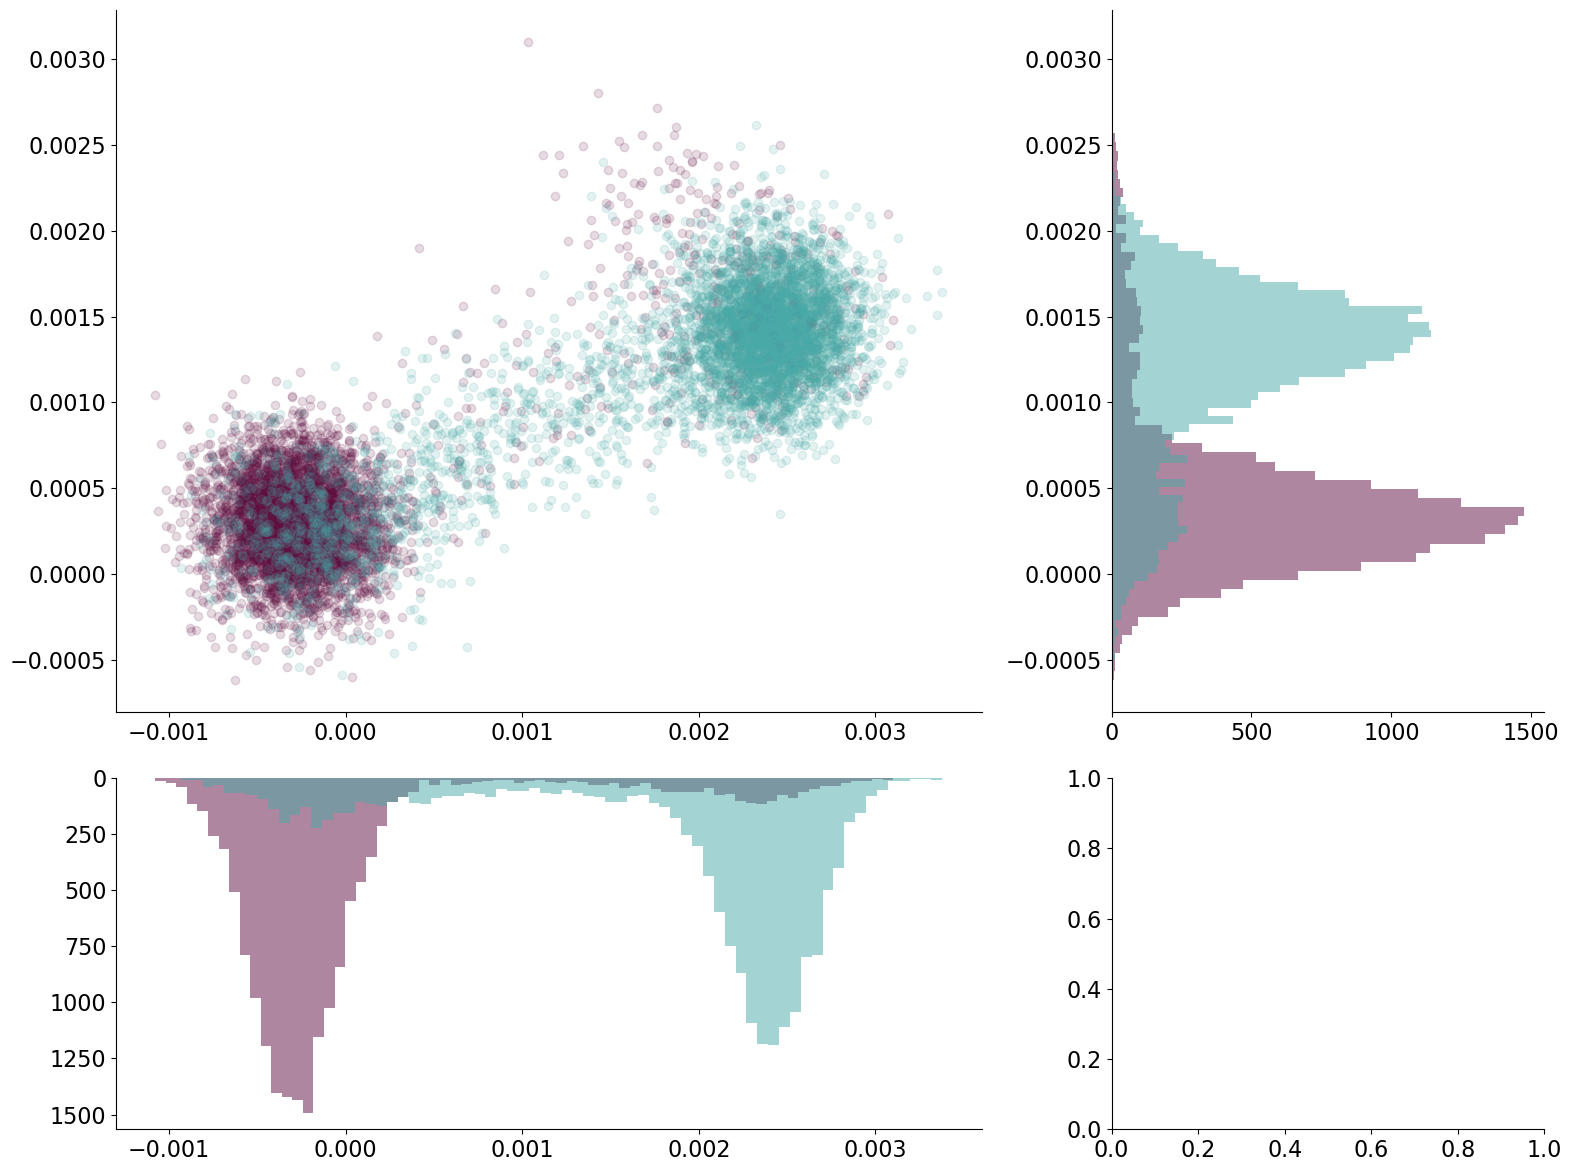

In [134]:
data_0 = IQ_state_0[2]
data_1 = IQ_state_1[2]

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (16, 12),
                       gridspec_kw = {"width_ratios": [2, 1], "height_ratios": [2, 1]})

ax_main = ax[0, 0]
ax_main.scatter(data_0.real, data_0.imag, alpha = 0.15, color = "C0");
ax_main.scatter(data_1.real, data_1.imag, alpha = 0.15, color = "C1");

ax_x = ax[1, 0]
ax_x.invert_yaxis()
ax_x.hist(data_0.real, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", density = True);
ax_x.hist(data_1.real, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", density = True);

ax_y = ax[0, 1]
ax_y.hist(data_0.imag, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);
ax_y.hist(data_1.imag, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);

fig.tight_layout()

In [135]:
# Initial guess
mu1_x, mu1_y = -0.5e-3,     0.5e-3
mu2_x, mu2_y = 2.5e-3,     2e-3
sigma        = 350.3e-6
f_1          = 0.100
f_broad      = 0.050

minimizer_2_ground = Minuit(lambda x: nllh(x, data_0), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_2_ground.fixed[-1] = True

minimizer_2_ground.limits = [(-1e-3, 0.), (0, 10e-4), (20e-4, 30e-4), (10e-4, 25e-4),  (1e-5, 5e-4), (0, 0.25), (0, 0.25)]
minimizer_2_ground.migrad()

xs, ys = np.linspace(data_0.real.min(), data_0.real.max(), 1000), np.linspace(data_0.imag.min(), data_0.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_2_ground.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C0", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

minimizer_2_ground

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.325e+05                 │              Nfcn = 213              │
│ EDM = 6.5e-05 (Goal: 0.0002)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  -288e-6  │   4e-6    │            │            │ -0.001  │    0    │       │
│ 1 │ x1   │  294e-6   │   4e-6    │            │            │    0    │  0.001  │       │
│ 2 │ x2   │ 2.252e-3  │ 0.015e-3  │            │            │  0.002  │  0.003  │       │
│ 3 │ x3   │ 1.621e-3  │ 0.013e-3  │            │            │  0.001  │ 0.0025  │       │
│ 4 │ x4   │ 262.8e-6  │  1.9e-6   │            │            │  1e-05  │ 0.0005  │       │
│ 5 │ x5   │   0.077   │   0.004   │            │            │    0    │  0.25   │       │
│ 6 │ x6   │   0.035   │   0.004   │            │            │    0    │  0.25   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │   1.6e-11  2.91e-13 -1.76e-12 -1.42e-13  2.85e-13   3.7e-10 -1.41e-09 │
│ x1 │  2.91e-13  1.56e-11  2.14e-13 -1.08e-12  1.33e-13  1.15e-10 -6.23e-10 │
│ x2 │ -1.76e-12  2.14e-13  2.35e-10  3.61e-11 -2.45e-12 -1.35e-08  1.72e-08 │
│ x3 │ -1.42e-13 -1.08e-12  3.61e-11  1.74e-10 -1.07e-12 -6.29e-09  7.89e-09 │
│ x4 │  2.85e-13  1.33e-13 -2.45e-12 -1.07e-12  3.75e-12  4.63e-10 -9.18e-10 │
│ x5 │   3.7e-10  1.15e-10 -1.35e-08 -6.29e-09  4.63e-10  1.74e-05 -4.66e-06 │
│ x6 │ -1.41e-09 -6.23e-10  1.72e-08  7.89e-09 -9.18e-10 -4.66e-06  1.44e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

In [136]:
# Initial guess
mu1_x, mu1_y = 2.5e-3,     2e-3
mu2_x, mu2_y = -0.5e-3,     0.5e-3
sigma        = 350.3e-6
f_1          = 0.100
f_broad      = 0.050


minimizer_2_excited = Minuit(lambda x: nllh(x, data_1), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_2_excited.fixed[-1] = True

minimizer_2_excited.limits = [(20e-4, 30e-4), (10e-4, 25e-4),  (-1e-3, 0.), (0, 10e-4), (1e-5, 5e-4), (0, 0.25), (0, 0.25)]
# minimizer_2_excited.limits = [ (-3e-4, 3e-4), (0, 5e-4), (5e-4, 15e-4), (5e-4, 15e-4), (1e-5, 4e-4), (0, .5), (0.00, 0.15)]
minimizer_2_excited.migrad()

xs, ys = np.linspace(data_1.real.min(), data_1.real.max(), 1000), np.linspace(data_1.imag.min(), data_1.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_2_excited.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C1", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

fig.show()

minimizer_2_excited

/tmp/ipykernel_8226/4207625549.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.284e+05                 │              Nfcn = 279              │
│ EDM = 1.49e-06 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 2.412e-3  │ 0.005e-3  │            │            │  0.002  │  0.003  │       │
│ 1 │ x1   │ 1.428e-3  │ 0.004e-3  │            │            │  0.001  │ 0.0025  │       │
│ 2 │ x2   │ -0.225e-3 │ 0.015e-3  │            │            │ -0.001  │    0    │       │
│ 3 │ x3   │ 0.259e-3  │ 0.011e-3  │            │            │    0    │  0.001  │       │
│ 4 │ x4   │ 267.2e-6  │  2.1e-6   │            │            │  1e-05  │ 0.0005  │       │
│ 5 │ x5   │   0.103   │   0.006   │            │            │    0    │  0.25   │       │
│ 6 │ x6   │   0.185   │   0.008   │            │            │    0    │  0.25   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  2.33e-11     2e-12 -4.47e-12 -1.37e-13 -1.33e-12 -1.78e-09  8.49e-09 │
│ x1 │     2e-12  1.96e-11 -5.55e-14 -3.81e-12 -5.63e-13 -6.94e-10  3.65e-09 │
│ x2 │ -4.47e-12 -5.55e-14  2.13e-10  5.43e-11  4.42e-12  3.57e-08  -4.4e-08 │
│ x3 │ -1.37e-13 -3.81e-12  5.43e-11  1.12e-10  1.89e-12  1.54e-08 -1.91e-08 │
│ x4 │ -1.33e-12 -5.63e-13  4.42e-12  1.89e-12  4.64e-12  1.33e-09 -3.18e-09 │
│ x5 │ -1.78e-09 -6.94e-10  3.57e-08  1.54e-08  1.33e-09  3.29e-05 -2.23e-05 │
│ x6 │  8.49e-09  3.65e-09  -4.4e-08 -1.91e-08 -3.18e-09 -2.23e-05  6.67e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

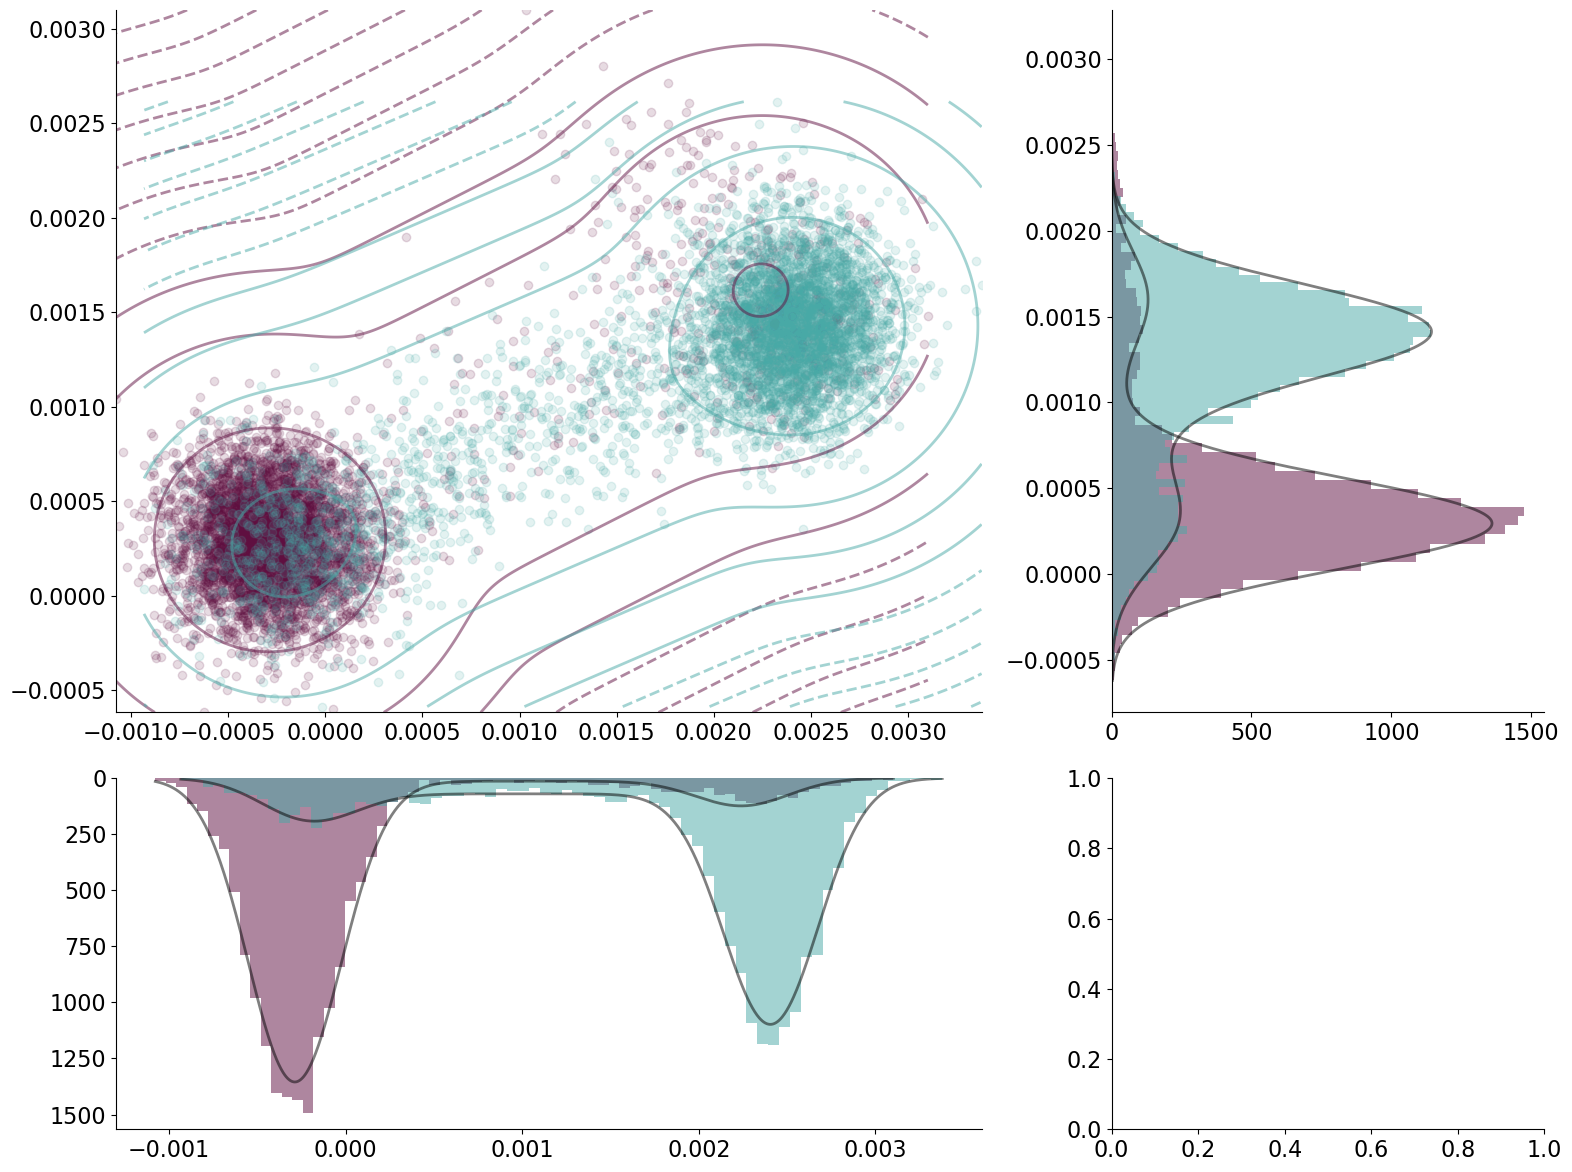

In [137]:
fig

## Fitting 5 $\mu s$

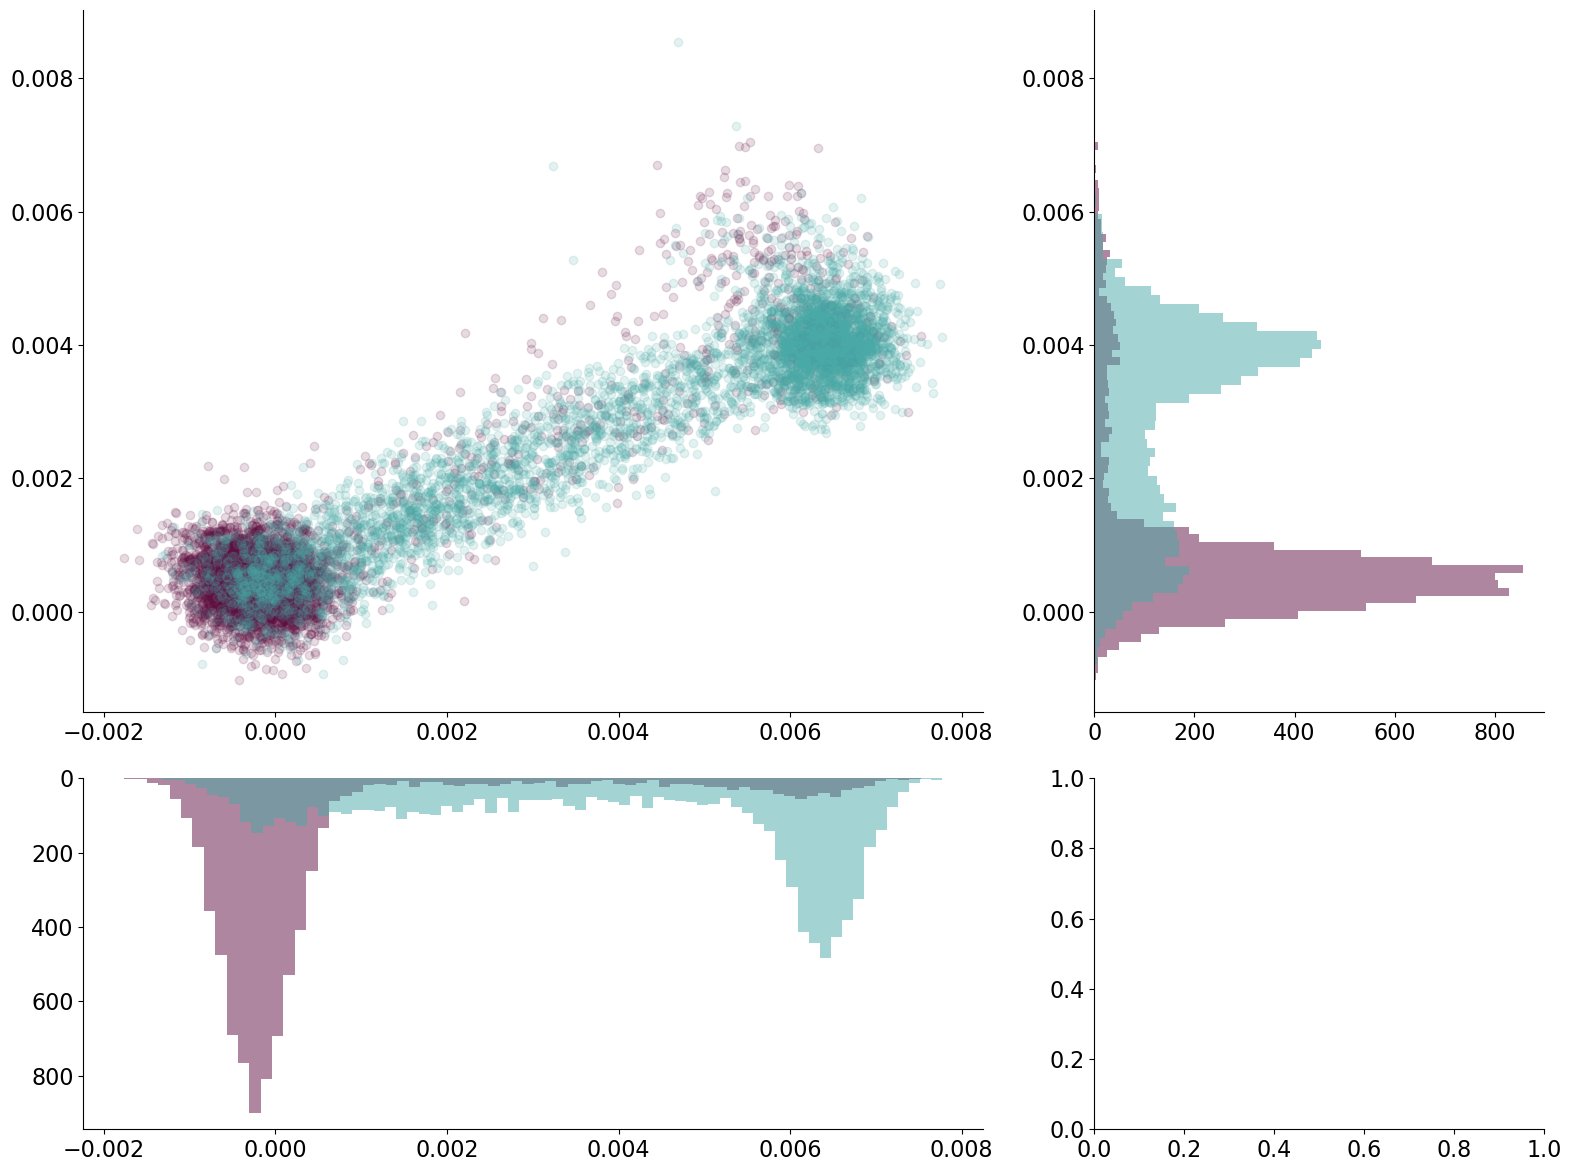

In [138]:
data_0 = IQ_state_0[3]
data_1 = IQ_state_1[3]

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (16, 12),
                       gridspec_kw = {"width_ratios": [2, 1], "height_ratios": [2, 1]})

ax_main = ax[0, 0]
ax_main.scatter(data_0.real, data_0.imag, alpha = 0.15, color = "C0");
ax_main.scatter(data_1.real, data_1.imag, alpha = 0.15, color = "C1");

ax_x = ax[1, 0]
ax_x.invert_yaxis()
ax_x.hist(data_0.real, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", density = True);
ax_x.hist(data_1.real, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", density = True);

ax_y = ax[0, 1]
ax_y.hist(data_0.imag, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);
ax_y.hist(data_1.imag, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);

fig.tight_layout()

In [139]:
# Initial guess
mu1_x, mu1_y = -0.5e-3,     0.5e-3
mu2_x, mu2_y = 7e-3,        5e-3
sigma        = 350.3e-6
f_1          = 0.100
f_broad      = 0.050

minimizer_5_ground = Minuit(lambda x: nllh(x, data_0), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_5_ground.fixed[-1] = True

minimizer_5_ground.limits = [(-1e-3, 1e3), (0, 2e-3), (20e-4, 30e-3), (10e-4, 25e-3),  (1e-5, 5e-4), (0, 0.25), (0, 0.25)]
minimizer_5_ground.migrad()

xs, ys = np.linspace(data_0.real.min(), data_0.real.max(), 1000), np.linspace(data_0.imag.min(), data_0.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_5_ground.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C0", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

minimizer_5_ground

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.205e+05                 │              Nfcn = 218              │
│ EDM = 4.31e-05 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  -214e-6  │   7e-6    │            │            │ -0.001  │  1000   │       │
│ 1 │ x1   │  456e-6   │   7e-6    │            │            │    0    │  0.002  │       │
│ 2 │ x2   │ 6.128e-3  │ 0.028e-3  │            │            │  0.002  │  0.03   │       │
│ 3 │ x3   │ 4.637e-3  │ 0.024e-3  │            │            │  0.001  │  0.025  │       │
│ 4 │ x4   │ 443.6e-6  │  3.3e-6   │            │            │  1e-05  │ 0.0005  │       │
│ 5 │ x5   │   0.061   │   0.004   │            │            │    0    │  0.25   │       │
│ 6 │ x6   │   0.084   │   0.005   │            │            │    0    │  0.25   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  4.71e-11   1.5e-12 -4.13e-12  2.77e-12  8.31e-13   2.8e-10 -2.27e-09 │
│ x1 │   1.5e-12  4.57e-11  1.79e-12  -6.3e-12   5.5e-13  2.23e-10 -1.51e-09 │
│ x2 │ -4.13e-12  1.79e-12  7.73e-10  2.18e-10 -5.49e-12 -2.56e-08   2.9e-08 │
│ x3 │  2.77e-12  -6.3e-12  2.18e-10  5.98e-10 -3.53e-12 -1.72e-08  1.92e-08 │
│ x4 │  8.31e-13   5.5e-13 -5.49e-12 -3.53e-12  1.09e-11  5.06e-10  -1.2e-09 │
│ x5 │   2.8e-10  2.23e-10 -2.56e-08 -1.72e-08  5.06e-10  1.48e-05 -4.94e-06 │
│ x6 │ -2.27e-09 -1.51e-09   2.9e-08  1.92e-08  -1.2e-09 -4.94e-06  2.29e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

In [140]:
# Initial guess
mu1_x, mu1_y = 7e-3,        5e-3
mu2_x, mu2_y = -0.5e-3,     0.5e-3
sigma        = 350.3e-6
f_1          = 0.100
f_broad      = 0.050


minimizer_5_excited = Minuit(lambda x: nllh(x, data_1), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_5_excited.fixed[-1] = True

minimizer_5_excited.limits = [(5e-3, 10e-3), (3e-3, 7e-3),  (-1e-3, 1e-3), (-1e-3, 1e-3), (1e-5, 5e-4), (0, 0.25), (0, 0.50)]
# minimizer_5_excited.limits = [ (-3e-4, 3e-4), (0, 5e-4), (5e-4, 15e-4), (5e-4, 15e-4), (1e-5, 4e-4), (0, .5), (0.00, 0.15)]
minimizer_5_excited.migrad()

xs, ys = np.linspace(data_1.real.min(), data_1.real.max(), 1000), np.linspace(data_1.imag.min(), data_1.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_5_excited.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C1", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

fig.show()

minimizer_5_excited

/tmp/ipykernel_8226/2754966195.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.115e+05                 │              Nfcn = 343              │
│ EDM = 0.000143 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 6.393e-3  │ 0.011e-3  │            │            │  0.005  │  0.01   │       │
│ 1 │ x1   │ 4.111e-3  │ 0.009e-3  │            │            │  0.003  │  0.007  │       │
│ 2 │ x2   │ -0.090e-3 │ 0.024e-3  │            │            │ -0.001  │  0.001  │       │
│ 3 │ x3   │ 0.493e-3  │ 0.017e-3  │            │            │ -0.001  │  0.001  │       │
│ 4 │ x4   │  469e-6   │   4e-6    │            │            │  1e-05  │ 0.0005  │       │
│ 5 │ x5   │   0.111   │   0.006   │            │            │    0    │  0.25   │       │
│ 6 │ x6   │   0.443   │   0.010   │            │            │    0    │   0.5   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  1.13e-10  1.89e-11 -1.44e-11  5.09e-12 -4.55e-12 -2.65e-09  2.06e-08 │
│ x1 │  1.89e-11  8.92e-11  5.01e-12 -1.94e-11 -2.46e-12 -1.31e-09  1.13e-08 │
│ x2 │ -1.44e-11  5.01e-12  5.98e-10  2.38e-10  1.44e-11  7.85e-08 -8.65e-08 │
│ x3 │  5.09e-12 -1.94e-11  2.38e-10  3.03e-10  7.98e-12  4.35e-08  -4.8e-08 │
│ x4 │ -4.55e-12 -2.46e-12  1.44e-11  7.98e-12  1.61e-11  2.53e-09 -4.67e-09 │
│ x5 │ -2.65e-09 -1.31e-09  7.85e-08  4.35e-08  2.53e-09  4.13e-05 -3.42e-05 │
│ x6 │  2.06e-08  1.13e-08 -8.65e-08  -4.8e-08 -4.67e-09 -3.42e-05  9.29e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

## Fitting 10 $\mu s$

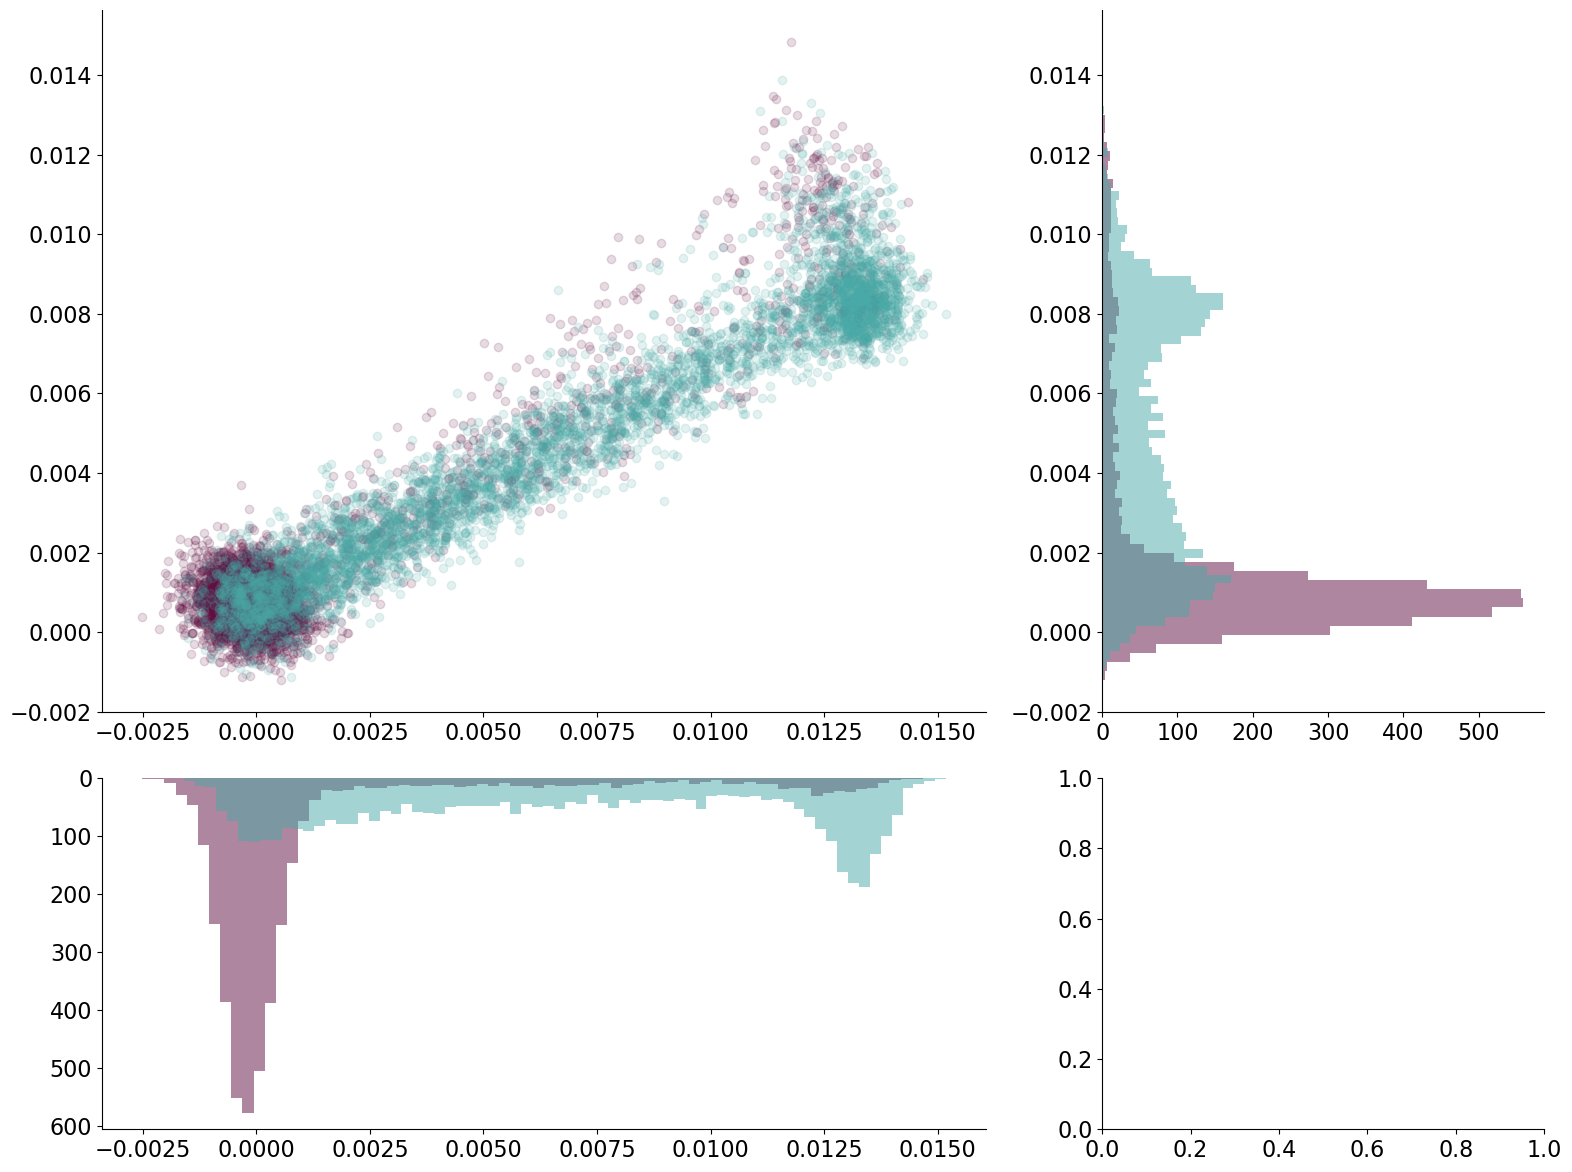

In [141]:
data_0 = IQ_state_0[4]
data_1 = IQ_state_1[4]

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (16, 12),
                       gridspec_kw = {"width_ratios": [2, 1], "height_ratios": [2, 1]})

ax_main = ax[0, 0]
ax_main.scatter(data_0.real, data_0.imag, alpha = 0.15, color = "C0");
ax_main.scatter(data_1.real, data_1.imag, alpha = 0.15, color = "C1");

ax_x = ax[1, 0]
ax_x.invert_yaxis()
ax_x.hist(data_0.real, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", density = True);
ax_x.hist(data_1.real, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", density = True);

ax_y = ax[0, 1]
ax_y.hist(data_0.imag, bins = 70, alpha = 0.5, color = "C0", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);
ax_y.hist(data_1.imag, bins = 70, alpha = 0.5, color = "C1", linewidth = 4, histtype = "stepfilled", orientation = "horizontal", density = True);

fig.tight_layout()

In [142]:
# Initial guess
mu1_x, mu1_y = -0.5e-3,     0.5e-3
mu2_x, mu2_y = 7e-3,        8e-3
sigma        = 350.3e-6
f_1          = 0.100
f_broad      = 0.050

minimizer_10_ground = Minuit(lambda x: nllh(x, data_0), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_10_ground.fixed[-1] = True

minimizer_10_ground.limits = [(-2e-3, 2e3), (-2e-3, 2e-3), (10e-3, 20e-3), (5e-3, 15e-3),  (1e-5, 1e-3), (0, 0.25), (0, 0.25)]
minimizer_10_ground.migrad()

xs, ys = np.linspace(data_0.real.min(), data_0.real.max(), 1000), np.linspace(data_0.imag.min(), data_0.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_10_ground.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C0", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

minimizer_10_ground

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.108e+05                 │              Nfcn = 320              │
│ EDM = 6.82e-05 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ -0.157e-3 │ 0.010e-3  │            │            │ -0.002  │  2000   │       │
│ 1 │ x1   │  0.73e-3  │  0.01e-3  │            │            │ -0.002  │  0.002  │       │
│ 2 │ x2   │ 13.01e-3  │  0.06e-3  │            │            │  0.01   │  0.02   │       │
│ 3 │ x3   │  9.98e-3  │  0.05e-3  │            │            │  0.005  │  0.015  │       │
│ 4 │ x4   │  656e-6   │   5e-6    │            │            │  1e-05  │  0.001  │       │
│ 5 │ x5   │  0.0316   │  0.0033   │            │            │    0    │  0.25   │       │
│ 6 │ x6   │   0.149   │   0.006   │            │            │    0    │  0.25   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  1.07e-10  5.09e-12 -1.18e-11  1.69e-11  2.16e-12  1.86e-10 -3.56e-09 │
│ x1 │  5.09e-12  1.03e-10  2.96e-12 -3.13e-11  1.63e-12  5.43e-10 -2.92e-09 │
│ x2 │ -1.18e-11  2.96e-12  3.66e-09  1.88e-09 -2.06e-11 -9.02e-08  9.68e-08 │
│ x3 │  1.69e-11 -3.13e-11  1.88e-09  2.54e-09 -1.52e-11  -6.7e-08  7.17e-08 │
│ x4 │  2.16e-12  1.63e-12 -2.06e-11 -1.52e-11  2.49e-11  8.28e-10 -1.96e-09 │
│ x5 │  1.86e-10  5.43e-10 -9.02e-08  -6.7e-08  8.28e-10  1.11e-05 -6.33e-06 │
│ x6 │ -3.56e-09 -2.92e-09  9.68e-08  7.17e-08 -1.96e-09 -6.33e-06  3.46e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

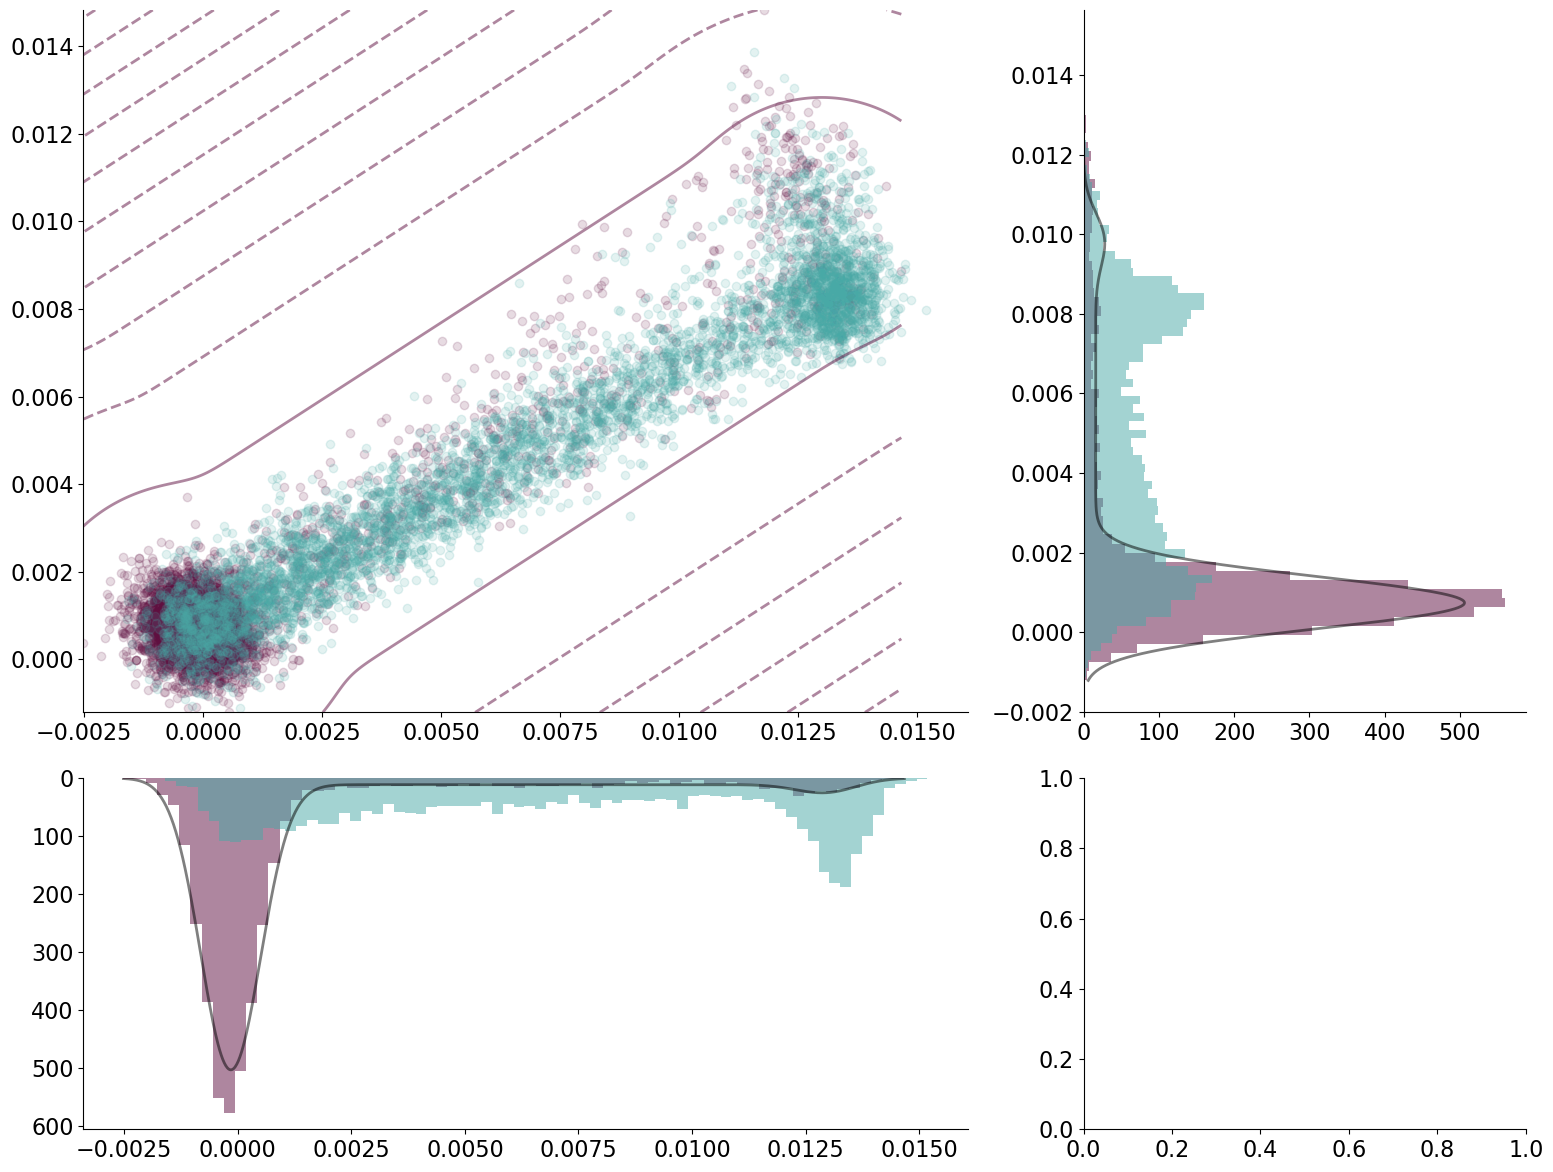

In [143]:
fig

In [144]:
# Initial guess
mu1_x, mu1_y = 12e-3,       8e-3
mu2_x, mu2_y = -0.5e-3,     0.5e-3
sigma        = 350.3e-6
f_1          = 0.100
f_broad      = 0.050

minimizer_10_excited = Minuit(lambda x: nllh(x, data_1), (mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_1, f_broad))
# minimizer_10_excited.fixed[-1] = True

minimizer_10_excited.limits = [(10e-3, 20e-3), (5e-3, 15e-3), (-2e-3, 2e3), (-2e-3, 2e-3), (1e-5, 1e-3), (0, 0.50), (0, 0.70)]
minimizer_10_excited.migrad()

xs, ys = np.linspace(data_1.real.min(), data_1.real.max(), 1000), np.linspace(data_1.imag.min(), data_1.imag.max(), 1000)

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

X,  Y  = np.meshgrid(xs, ys)

Z = double_gauss_with_broad(np.vstack([X.flatten(), Y.flatten()]).T, minimizer_10_excited.values).reshape(X.shape)

ax_main.contour(X, Y, np.log(Z), levels = 10, colors = "C1", linewidths = 2, alpha = 0.5)

ax_x.plot(xs, Z.sum(axis = 0) * (ys[1] - ys[0]), color = "k", linewidth = 2, alpha = 0.5)
ax_y.plot(Z.sum(axis = 1) * (xs[1] - xs[0]), ys, color = "k", linewidth = 2, alpha = 0.5)

fig.show()

minimizer_10_excited

/tmp/ipykernel_8226/771142197.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.87e+04                  │              Nfcn = 343              │
│ EDM = 6.3e-06 (Goal: 0.0002)     │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 13.201e-3 │ 0.024e-3  │            │            │  0.01   │  0.02   │       │
│ 1 │ x1   │ 8.683e-3  │ 0.020e-3  │            │            │  0.005  │  0.015  │       │
│ 2 │ x2   │ 0.178e-3  │ 0.032e-3  │            │            │ -0.002  │  2000   │       │
│ 3 │ x3   │ 0.847e-3  │ 0.024e-3  │            │            │ -0.002  │  0.002  │       │
│ 4 │ x4   │  743e-6   │   7e-6    │            │            │  1e-05  │  0.001  │       │
│ 5 │ x5   │   0.167   │   0.007   │            │            │    0    │   0.5   │       │
│ 6 │ x6   │   0.605   │   0.010   │            │            │    0    │   0.7   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  5.56e-10  1.59e-10 -4.82e-11  1.39e-11 -1.65e-11 -6.51e-09  5.42e-08 │
│ x1 │  1.59e-10  3.92e-10  1.68e-11 -6.71e-11  -9.9e-12 -3.95e-09  3.33e-08 │
│ x2 │ -4.82e-11  1.68e-11  1.03e-09   4.4e-10  4.75e-11   1.1e-07 -1.19e-07 │
│ x3 │  1.39e-11 -6.71e-11   4.4e-10  5.63e-10  2.87e-11  6.62e-08 -7.25e-08 │
│ x4 │ -1.65e-11  -9.9e-12  4.75e-11  2.87e-11  4.67e-11  7.48e-09 -1.01e-08 │
│ x5 │ -6.51e-09 -3.95e-09   1.1e-07  6.62e-08  7.48e-09  5.27e-05 -4.77e-05 │
│ x6 │  5.42e-08  3.33e-08 -1.19e-07 -7.25e-08 -1.01e-08 -4.77e-05  9.42e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

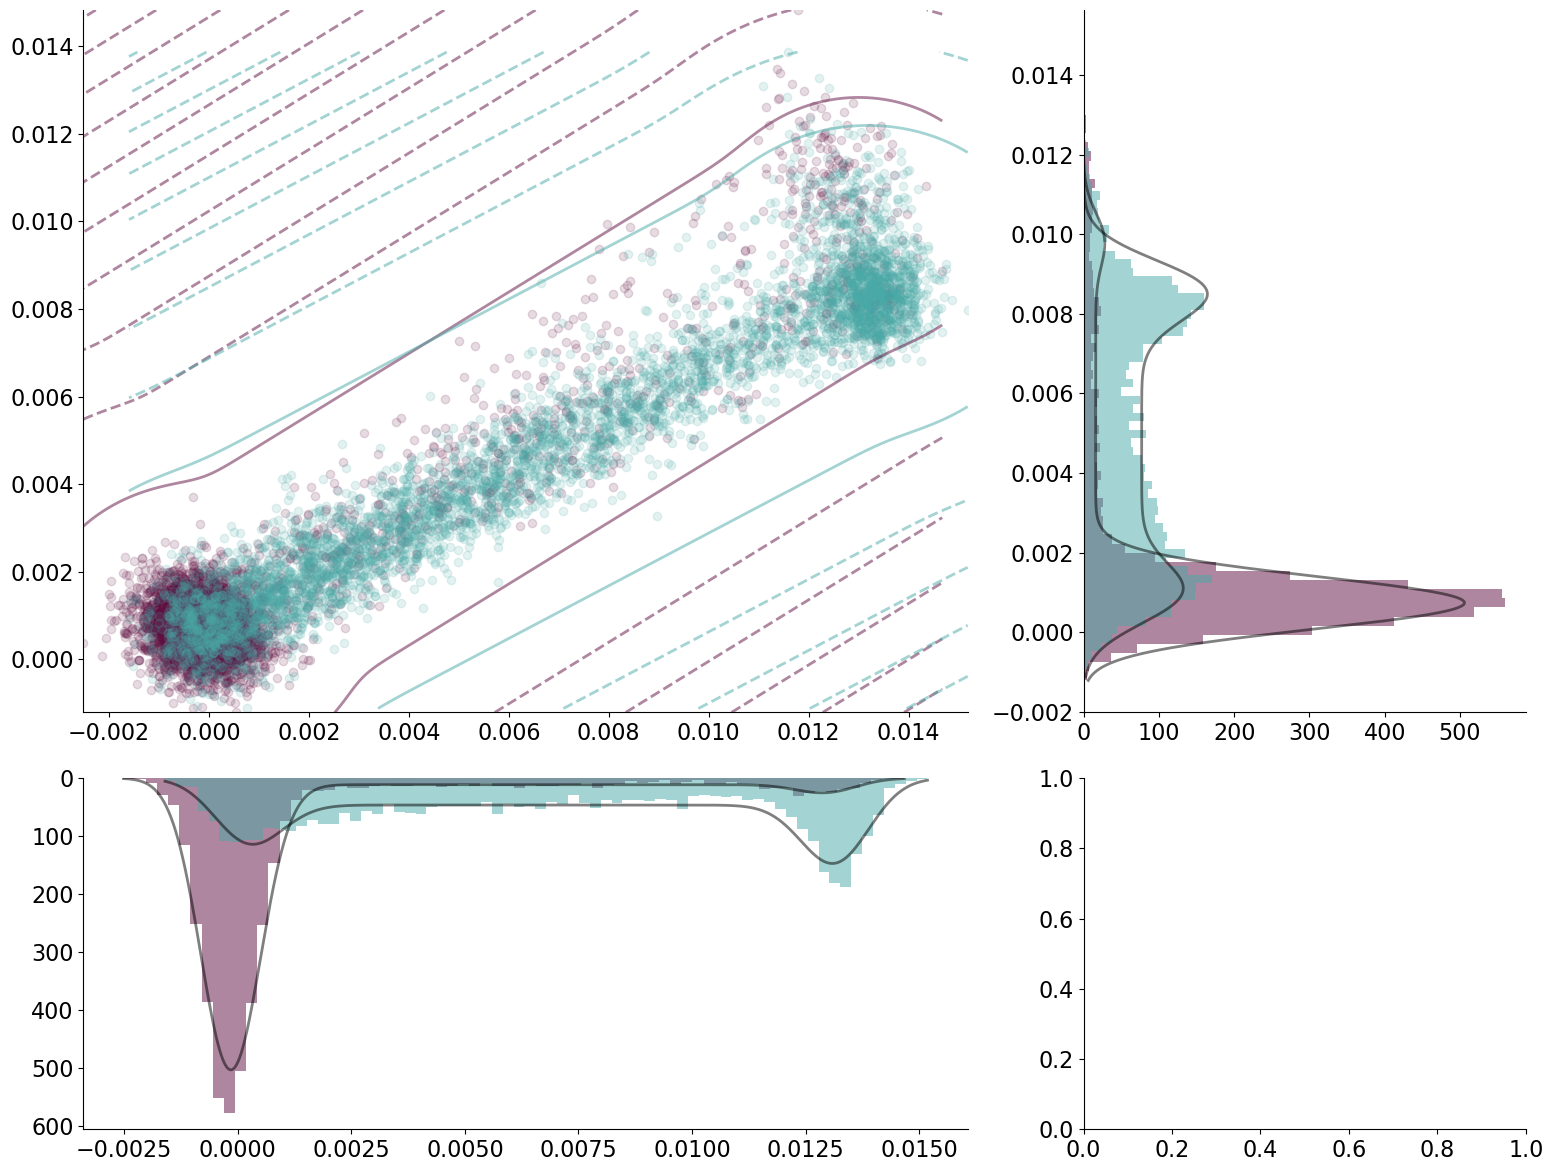

In [145]:
fig

# Evolution of the Parameters

In [146]:
ground_fits     = [minimizer_0_5_ground, minimizer_1_ground, minimizer_2_ground, minimizer_5_ground, minimizer_10_ground]
excited_fits    = [minimizer_0_5_excited, minimizer_1_excited, minimizer_2_excited, minimizer_5_excited, minimizer_10_excited]

ground_params   = np.vstack([np.array(fit.values) for fit in ground_fits])
excited_params  = np.vstack([np.array(fit.values) for fit in excited_fits])

ground_errors   = np.vstack([np.array(fit.errors) for fit in ground_fits])
excited_errors  = np.vstack([np.array(fit.errors) for fit in excited_fits])

The last point is not included as we have a first order approximation. Thus we are not including multiple transitions $\ket{0} \to \ket{1} \to \ket{0}$. So this only holds when the transitions times are much smaller than the considered interval. For a start at $\ket{0}$ This transitions is not bad within the first 10 $\mu s$. But with a $T_{1\downarrow} \approx 10\mu s$ the point at $t = 10 \mu s$ of $\ket{1}$ is neglected. This is also supported by the fact that the fraction would be around $\approx 80 \%$ if it was included. This can no be assumed to behave like $\ket{1}$.

We find:
Ground Initial	intercept: 8.3  +- 0.3 % 	slope: -0.5  +- 0.1 % 	chi2: 3.3 	 pval: 0.353
Ground Decay	intercept: 1.4  +- 0.4 % 	slope: 1.4  +- 0.1 % 	chi2: 6.2 	 pval: 0.103
 
Excited Initial	intercept: 9.2  +- 0.5 % 	slope: 0.4  +- 0.2 % 	chi2: 0.9 	 pval: 0.634
Excited Decay	intercept: 0.8  +- 0.8 % 	slope: 8.7  +- 0.3 % 	chi2: 2.2 	 pval: 0.326


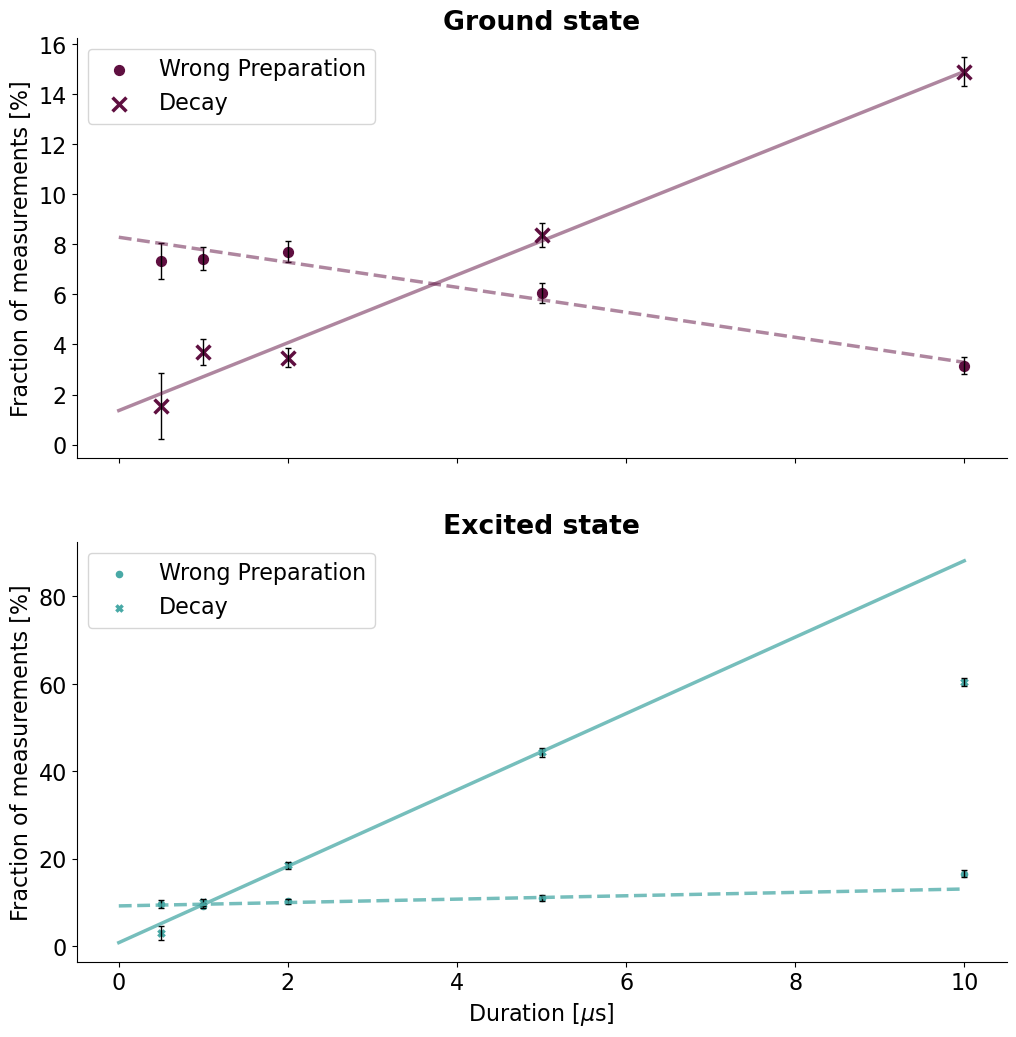

In [147]:
from scipy.stats import chi2

fig, axes = plt.subplots(nrows = 2, figsize = (12, 12), sharex = True)

ax = axes[0]
ax.scatter(durations,  100 *ground_params[:, -2], color = "C0", marker = "o", s = 50, ls = "None", label = "Wrong Preparation")
ax.errorbar(durations, 100 *ground_params[:, -2], yerr = 100 * ground_errors[:, -2], color = "k", ls = "None", capsize = 2, elinewidth = 1)

ax.scatter(durations,  100 *ground_params[:, -1], color = "C0", marker = "x", s = 100, ls = "None", label = "Decay")
ax.errorbar(durations, 100 *ground_params[:, -1], yerr = 100 * ground_errors[:, -1], color = "k", ls = "None", capsize = 2, elinewidth = 1)

ax.set(
    # xlabel = "Duration [$\mu$s]",
    ylabel = "Fraction of measurements [%]",
    title  = "Ground state"
)

ax = axes[1]
ax.scatter(durations,  100 *excited_params[:, -2], color = "C1", marker = "o", s = 20, ls = "None", label = "Wrong Preparation")
ax.errorbar(durations, 100 *excited_params[:, -2], yerr = 100 * excited_errors[:, -2], color = "k", ls = "None", capsize = 2, elinewidth = 1)

ax.scatter(durations,  100 *excited_params[:, -1], color = "C1", marker = "x", s = 20, ls = "None", label = "Decay")
ax.errorbar(durations, 100 *excited_params[:, -1], yerr = 100 * excited_errors[:, -1], color = "k", ls = "None", capsize = 2, elinewidth = 1)

ax.set(
    xlabel = "Duration [$\mu$s]",
    ylabel = "Fraction of measurements [%]",
    title  = "Excited state"
)

axes[0].legend()
axes[1].legend()
from iminuit.cost import LeastSquares

lin = lambda x, a, b: a * x + b

def lin_regress(x, y, errs):
    cost = LeastSquares(x, y, errs, lin)
    minimizer = Minuit(cost, a = 1, b = 0)
    minimizer.migrad()
    return minimizer

exp = lambda x, t1, scaling: scaling * (1 - np.exp(-x / t1)) 

def exp_regress(x, y, errs):
    cost = LeastSquares(x, y, errs, exp)
    minimizer = Minuit(cost, t1 = 1, scaling = 1)
    minimizer.migrad()
    return minimizer


ground_initial  = lin_regress(durations[:], ground_params[:, -2], ground_errors[:, -2])
ground_decay    = lin_regress(durations[:], ground_params[:, -1], ground_errors[:, -1])

excited_initial = lin_regress(durations[:-1], excited_params[:-1, -2], excited_errors[:-1, -2])
excited_decay   = lin_regress(durations[:-1], excited_params[:-1, -1], excited_errors[:-1, -1])

ts = np.linspace(0, 10, 100)
axes[0].plot(ts, 100 * lin(ts, *ground_initial.values), marker = "None", ls = "--", color = "C0", alpha = 0.50 )
axes[0].plot(ts, 100 * lin(ts ,*ground_decay.values),   marker = "None", ls = "-", color = "C0", alpha = 0.50 )

axes[1].plot(ts, 100 * lin(ts, *excited_initial.values), marker = "None", ls = "--", color = "C1", alpha = 0.75 )
axes[1].plot(ts, 100 * lin(ts ,*excited_decay.values),   marker = "None", ls = "-", color = "C1", alpha = 0.75 )

def print_linear(name, minimizer):
    string = f"{name}\t"

    string += f"intercept: {100 * minimizer.values[1]:.1f}  +- {100 * minimizer.errors[1]:.1f} % \t"
    string += f"slope: {100 * minimizer.values[0]:.1f}  +- {100 * minimizer.errors[0]:.1f} % \t"
    string += f"chi2: {minimizer.fval:.1f} \t pval: {chi2.sf(minimizer.fval, minimizer.ndof):.3f}"

    print(string)


def print_exponential(name, minimizer):
    string = f"{name}\t"

    string += f"t1:        {minimizer.values[0]:.1f} +- {minimizer.errors[0]:.1f} \t"
    string += f"scaling: {minimizer.values[1]:.1f} +- {minimizer.errors[1]:.1f} \t"
    string += f"chi2: {minimizer.fval:.1f} \t, pval: {chi2.sf(minimizer.fval, minimizer.ndof):.3f}"

    print(string)



print("We find:")
print_linear("Ground Initial", ground_initial)
print_linear("Ground Decay", ground_decay)

print(" ")
print_linear("Excited Initial", excited_initial)
print_linear("Excited Decay", excited_decay)


fig.savefig(os.path.join(figures_path, "fraction_evolution.pdf"))

__Evolution of position and width of the distributions__

In [148]:
I_distance = abs(ground_params[:, 0] - excited_params[:, 0])
I_err      = np.sqrt(ground_errors[:, 0]**2 + excited_errors[:, 0]**2)

Q_distance = abs(ground_params[:, 1] - excited_params[:, 1])
Q_err      = np.sqrt(ground_errors[:, 1]**2 + excited_errors[:, 1]**2)

total_dist = np.sqrt(I_distance**2 + Q_distance**2)
total_err  = 1 / total_dist * np.linalg.norm([I_distance * I_err, Q_distance * Q_err])

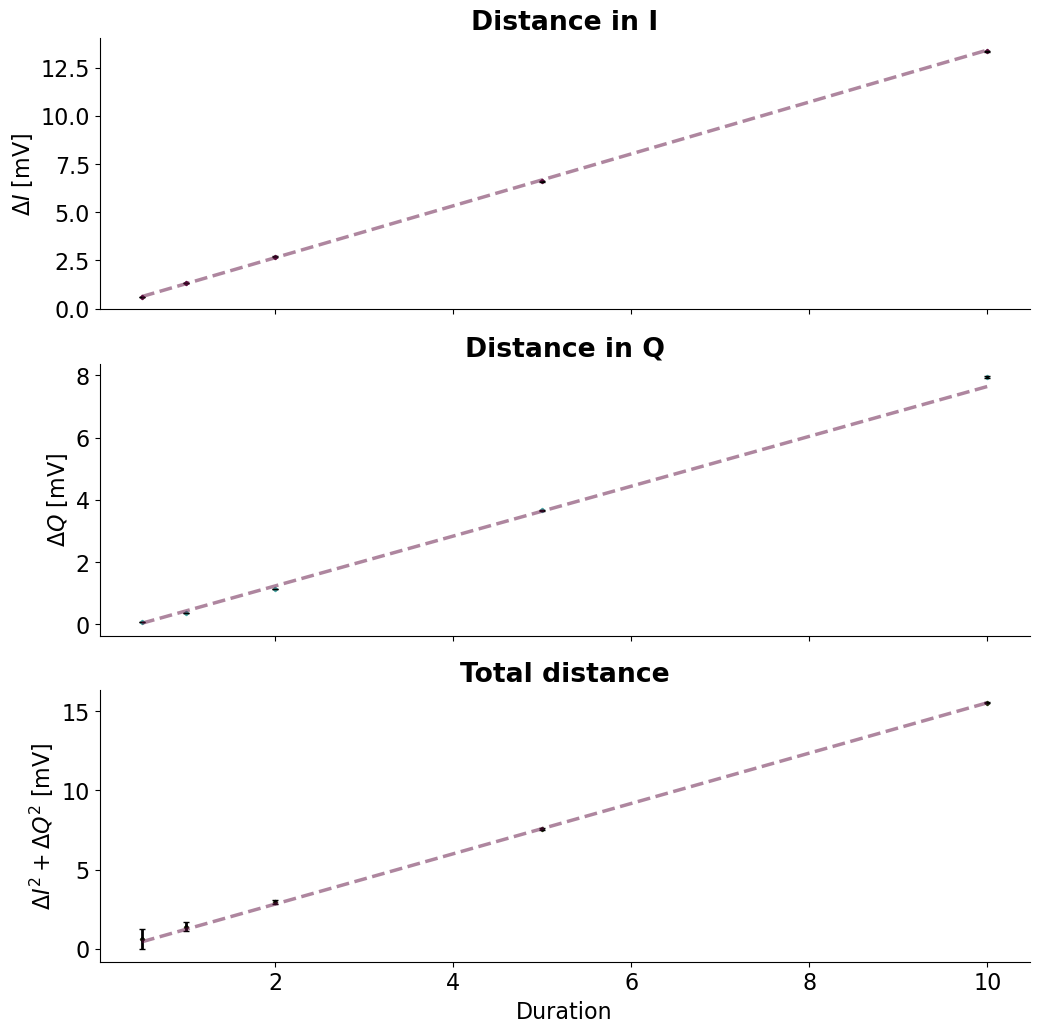

In [149]:
fig, axes = plt.subplots(nrows = 3, figsize = (12, 12), sharex = True)

ax = axes[0]
ax.set(
    title = "Distance in I",
    # xlabel = "Duration",
    ylabel = "$\Delta I$ [mV]"
)

ax.scatter(durations, 1000 * I_distance, color = "C0", marker = "x", s = 5, ls = "None", label = "I")
ax.errorbar(durations, 1000 * I_distance, yerr =1000 *  I_err, color = "k", ls = "None", capsize = 2, elinewidth = 2)

I_fit = lin_regress(durations, I_distance, I_err)

ax.plot(durations, 1000 * lin(durations, *I_fit.values), color = "C0", ls = "--", alpha = 0.5)


ax = axes[1]
ax.set(
    title = "Distance in Q",
    # xlabel = "Duration",
    ylabel = "$\Delta Q$ [mV]"
)

ax.scatter(durations, 1000 *  Q_distance, color = "C1", marker = "x", s = 5, ls = "None", label = "Q")
ax.errorbar(durations, 1000 *  Q_distance, yerr = 1000 *  Q_err, color = "k", ls = "None", capsize = 2, elinewidth = 2)

Q_fit = lin_regress(durations, Q_distance, Q_err)

ax.plot(durations, 1000 * lin(durations, *Q_fit.values), color = "C0", ls = "--", alpha = 0.5)

ax = axes[2]
ax.set(
    title = "Total distance",
    xlabel = "Duration",
    ylabel = "$\Delta I^2 + \Delta Q^2$ [mV]"
)

ax.scatter(durations, 1000 * total_dist, color = "C2", marker = "x", s = 5, ls = "None", label = "Total")
ax.errorbar(durations, 1000 * total_dist, yerr = 1000 * total_err, color = "k", ls = "None", capsize = 2, elinewidth = 2)

total_fit = lin_regress(durations, total_dist, total_err)

ax.plot(durations, 1000 * lin(durations, *total_fit.values), ls = "--", alpha = 0.5, color = "C0")



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.1 (chi2/ndof = 6.5)     │              Nfcn = 255              │
│ EDM = 3.03e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  265e-6   │   5e-6    │            │            │         │         │       │
│ 1 │ b    │ -0.179e-3 │ 0.016e-3  │            │            │         │         │       │
│ 2 │ c    │   0.82    │   0.10    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │  2.03e-11 -6.92e-11  4.07e-07 │
│ b │ -6.92e-11  2.45e-10 -1.48e-06 │
│ c │  4.07e-07 -1.48e-06   0.00905 │
└───┴───────────────────────────────┘

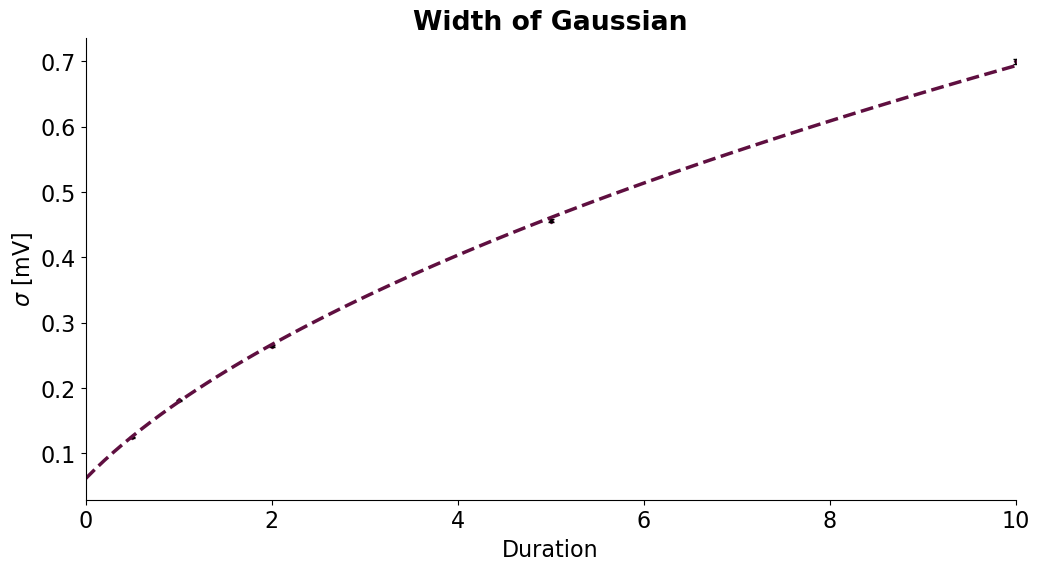

In [150]:
# Signal to Noise Ratio

avg_std     = (ground_params[:, 4] + excited_params[:, 4]) / 2
avg_std_err = np.sqrt(ground_errors[:, 4]**2 + excited_errors[:, 4]**2) / 2

fig, ax = plt.subplots(figsize = (12, 6))

ax.set(
    title = "Width of Gaussian",
    xlim = (0, 10),
    xlabel = "Duration",
    ylabel = "$\sigma$ [mV]"
)

ax.scatter(durations, 1000 * avg_std, color = "C0", marker = "x", s = 5, ls = "None", label = "Average")
ax.errorbar(durations, 1000 * avg_std, yerr = 1000 * avg_std_err, color = "k", ls = "None", capsize = 2, elinewidth = 2)

from iminuit.cost import LeastSquares
sqrt_func = lambda x, a, b, c: b + a * np.sqrt((x + c))
cost = LeastSquares(durations, avg_std, avg_std_err, sqrt_func)
minimizer = Minuit(cost, a = 1, b = 0, c = 1)
minimizer.limits[-1] = (0, None)
minimizer.migrad()

ax.plot(ts, 1000 * sqrt_func(ts, *minimizer.values),  color = "C0", ls = "--", label = "Linear")

minimizer

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.369 (chi2/ndof = 0.5)    │              Nfcn = 40               │
│ EDM = 6.71e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   6.23    │   0.19    │            │            │         │         │       │
│ 1 │ b    │    2.5    │    0.5    │            │            │         │         │       │
│ 2 │ c    │    0.0    │    0.1    │            │            │    0    │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │  0.0356 -0.0952       0 │
│ b │ -0.0952   0.265       0 │
│ c │       0       0       0 │
└───┴─────────────────────────┘

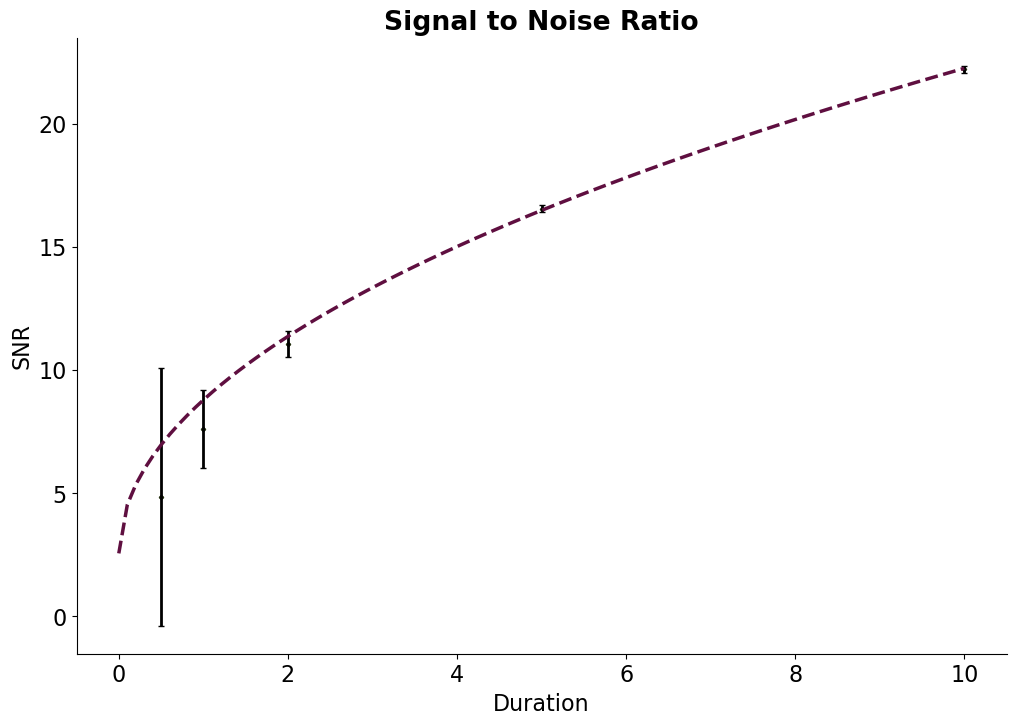

In [151]:
SNR         = total_dist / avg_std 
SNR_err     = SNR * np.sqrt((total_err / total_dist)**2 + (avg_std_err / avg_std)**2)

fig, ax = plt.subplots()

ax.set(
    title = "Signal to Noise Ratio",
    xlabel = "Duration",
    ylabel = "SNR"
)

ax.scatter(durations, SNR, color = "C2", marker = "x", s = 5, ls = "None", label = "Total")
ax.errorbar(durations, SNR, yerr = SNR_err, color = "k", ls = "None", capsize = 2, elinewidth = 2)

sqrt_func = lambda x, a, b, c: b + a * np.sqrt((x + c))
cost = LeastSquares(durations, SNR, SNR_err, sqrt_func)
minimizer = Minuit(cost, a = 1, b = 0, c = 0)
minimizer.limits[-1] = (0, None)
minimizer.fixed[2]  = True
minimizer.migrad()

ax.plot(ts, sqrt_func(ts, *minimizer.values),  color = "C0", ls = "--", label = "Linear")

minimizer

# Physical Parameters
We use the above approach to do some calibration. The following parameters are possible to find:
- $T_{1\uparrow}$ - decay time
- $T_{1\downarrow}$ - excitation time 
- The equilibrium distribution $\ket{0}$
- The x-gate fidelty 
- The temperature should be found from both comparing the rate of excitation/decay and from the equilibrium distribution.

### T1 Decay Times 

The actual distributions for these will be that the distribution will follow $(1 - e^{-t/T_1})$, or to first order $(t/T_1)$, which is what we have used in this fits. This is of course an approximation to low order in $t/T_1$. We correlate the slope to $T_1$ by $1 / \Gamma$, where $\Gamma$ is the slope/decay rate of the fit.

In [152]:
# Decay Times in microseconds
T1_decay = 1 / excited_decay.values["a"]

excited_decay_sample = np.random.normal(excited_decay.values["a"], excited_decay.errors["a"], size = 10000)
T1_error = (1 / excited_decay_sample).std()

print(f"Excited state decay time: T1-down: {T1_decay:.2f} +- {T1_error:.2f} us")


Excited state decay time: T1-down: 11.45 +- 0.38 us


In [153]:
# Test if ther decay of the little peak agrees with the decay of the big peak
T1_decay_2 =  (ground_initial.values["b"]  + 0.014) / ground_decay.values["a"]

excited_initial_sample = np.random.normal(ground_initial.values["b"], ground_initial.errors["b"], size = 10000)
excited_decay_sample = np.random.normal(ground_decay.values["a"], ground_decay.errors["a"], size = 10000)
T1_error_2 = (excited_initial_sample / excited_decay_sample).std()

print(f"Excited state decay time: T1-down: {T1_decay_2:.2f} +- {T1_error_2:.2f} us")


Excited state decay time: T1-down: 7.15 +- 0.42 us


In [154]:
# Excitation Times in microseconds
T1_decay = 1 / ground_decay.values["a"]

ground_decay_sample = np.random.normal(excited_decay.values["a"], ground_decay.errors["a"], size = 10000)
T1_error = (1 / ground_decay_sample).std()

print(f"Excited state decay time: T1-up: {T1_decay:.2f} +- {T1_error:.2f} us")


Excited state decay time: T1-up: 73.82 +- 0.10 us


The total decay rate is $\Gamma = \Gamma_{1\uparrow} + \Gamma_{1\downarrow}$

In [155]:
gamma = excited_decay.values["a"] + ground_decay.values["a"]
gamma_err = np.sqrt(excited_decay.errors["a"]**2 + ground_decay.errors["a"]**2)

print(f"Gamma: \t {gamma:.3f} +/- {gamma_err:.3f} us^-1")

T1_decay = 1 / gamma

gamma_decay_sample = np.random.normal(gamma, gamma_err, size = 10000)
T1_error = (1 / gamma_decay_sample).std()

print(f"T1: \t {T1_decay:.3f} +/- {T1_error:.3f} us")

Gamma: 	 0.101 +/- 0.003 us^-1
T1: 	 9.915 +/- 0.295 us


### Equilibrium Distributions and X-Gate Fidelty

We can chech the different distributions. To see the initial error:

In [156]:
# For the ground state we have 

ground_state_flipped        = ground_initial.values["b"] #+ ground_decay.values["b"]
ground_state_flipped_err    = np.sqrt(ground_initial.errors["b"] ** 2) #+ ground_decay.errors["b"] ** 2)

ground_state_correct        = 1 - ground_state_flipped

print(f"Ground state distribution: \tp_0: {ground_state_correct * 100:.1f} +- {ground_state_flipped_err * 100:.1f} %")
print(f"\t\t\t\tp_1: {ground_state_flipped * 100:.1f}  +- {ground_state_flipped_err * 100:.1f} %")

excited_state_flipped       = excited_initial.values["b"] #+ excited_decay.values["b"]
excited_state_flipped_err    = np.sqrt(excited_initial.errors["b"] ** 2) #+ excited_decay.errors["b"] ** 2)

excited_state_correct        = 1 - excited_state_flipped


print(f"Excited state distribution: \tp_0: {excited_state_correct * 100:.1f} +- {excited_state_flipped_err * 100:.1f} %")
print(f"\t\t\t\tp_1: {excited_state_flipped * 100:.1f}  +- {excited_state_flipped_err * 100:.1f} %")

Ground state distribution: 	p_0: 91.7 +- 0.3 %
				p_1: 8.3  +- 0.3 %
Excited state distribution: 	p_0: 90.8 +- 0.5 %
				p_1: 9.2  +- 0.5 %


In [157]:
x_gate_infidelty = ground_state_correct - excited_state_correct
x_gate_infidelty_err = np.sqrt(ground_state_flipped_err ** 2 + excited_state_flipped_err ** 2)

print(f"X gate infidelty: \t {x_gate_infidelty * 100:.1f} +- {x_gate_infidelty_err * 100:.1f} %")

X gate infidelty: 	 1.0 +- 0.6 %


__This is not as good measurement. Need to probably also consider the decay__

In [158]:
# For the ground state we have 

ground_state_flipped        = ground_initial.values["b"] + ground_decay.values["b"]
ground_state_flipped_err    = np.sqrt(ground_initial.errors["b"] ** 2 + ground_decay.errors["b"] ** 2)

ground_state_correct        = 1 - ground_state_flipped

print(f"Ground state distribution: \tp_0: {ground_state_correct * 100:.1f} +- {ground_state_flipped_err * 100:.1f} %")
print(f"\t\t\t\tp_1: {ground_state_flipped * 100:.1f}  +- {ground_state_flipped_err * 100:.1f} %")

excited_state_flipped       = excited_initial.values["b"] + excited_decay.values["b"]
excited_state_flipped_err    = np.sqrt(excited_initial.errors["b"] ** 2 + excited_decay.errors["b"] ** 2)

excited_state_correct        = 1 - excited_state_flipped


print(f"Excited state distribution: \tp_0: {excited_state_correct * 100:.1f} +- {excited_state_flipped_err * 100:.1f} %")
print(f"\t\t\t\tp_1: {excited_state_flipped * 100:.1f}  +- {excited_state_flipped_err * 100:.1f} %")

Ground state distribution: 	p_0: 90.4 +- 0.5 %
				p_1: 9.6  +- 0.5 %
Excited state distribution: 	p_0: 89.9 +- 1.0 %
				p_1: 10.1  +- 1.0 %


In [159]:
x_gate_infidelty = ground_state_correct - excited_state_correct
x_gate_infidelty_err = np.sqrt(ground_state_flipped_err ** 2 + excited_state_flipped_err ** 2)

print(f"X gate infidelty: \t {x_gate_infidelty * 100:.1f} +- {x_gate_infidelty_err * 100:.1f} %")

X gate infidelty: 	 0.5 +- 1.1 %


## Temperature
We now have two ways to find the temperature. The first is to use the equilibrium distribution and the second is to use the decay rate.

In equilibrium, the relation between the $p_1/p_0 = \tanh(-\beta \hbar \omega / 2)$, where $\omega$ is the energy difference between the two states.

We have the same relation between the two decay rates: $\Gamma_{1\uparrow} / \Gamma_{1\downarrow} = \exp(-\beta \hbar \omega)$

In [160]:
def occupation_to_temperature(p1, p0):
    return hbar * omega / (2 * kb * np.arctanh((p0 - p1)/ (p0 + p1)))

p1, p0 = ground_state_flipped, ground_state_correct

temp1 = occupation_to_temperature(p1, p0)

p1_sample, p0_sample    = np.random.normal(p1, ground_state_flipped_err, size = 10000), np.random.normal(p0, ground_state_flipped_err, size = 10000)
temp1_err               = occupation_to_temperature(p1_sample, p0_sample).std()

print(f"Temperature: \t {temp1 * 1000:.1f} +/- {temp1_err * 1000:.1f} mK")

Temperature: 	 127.9 +/- 2.9 mK


In [161]:
def rates_to_temperature(gamma1_up, gamma1_down):
    return hbar * omega / (- kb * np.log(gamma1_up / gamma1_down))

temp2 = rates_to_temperature(ground_decay.values["a"], excited_decay.values["a"])

gamma1_up_sample, gamma1_down_sample = np.random.normal(ground_decay.values["a"], ground_decay.errors["a"], size = 10000), np.random.normal(excited_decay.values["a"], excited_decay.errors["a"], size = 10000)
temp2_err = rates_to_temperature(gamma1_up_sample, gamma1_down_sample).std()

print(f"Temperature: \t {temp2 * 1000:.1f} +/- {temp2_err * 1000:.1f} mK")

Temperature: 	 153.6 +/- 5.4 mK
